<a href="https://colab.research.google.com/github/amelia188/LSTM-soil-moisture-forecasting/blob/main/soil_moisture_v3_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
!pip install keras-tcn tensorflow
!pip install optuna shap plotly
# --- Step 1: Imports and Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# specifically for the LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input
import tensorflow as tf

import shap
import plotly.express as px
import random
import time
from datetime import datetime, timedelta
from scipy import stats
import matplotlib.dates as mdates


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 163.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 166.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 186.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 97.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 122.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.5/585

# Data Import

In [ ]:
# prompt: i want to be asked to upload the dataset from my computer

from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# --- Load dataset ---
#df = pd.read_csv("/content/combined_hourly_data_cleaned.csv") #working from temp files
df = pd.read_csv("/content/drive/MyDrive/CERMES/combined_hourly_data_cleaned.csv") #working from the drive
#df = pd.read_csv("/Users/ameli/OneDrive/Documents/CERMES/combined_hourly_data_cleaned.csv") #working from pc

# Parse the datetime column
df['DateTime'] = pd.to_datetime(df['DateTime'], format="%d/%m/%Y %H:%M")
df = df.sort_values("DateTime").reset_index(drop=True)

df.describe()

,DateTime,Temp_C,Hum_%,WindSpeed_kmph,HeatIndex_C,Rain_mm,RainRate_mmph,ET_mm,SH1_SoilMoisture_4in_kPa,SH1_SoilMoisture_20in_kPa,SH1_SoilMoisture_36in_kPa
count,15724,15724.000000,15724.000000,15724.000000,15724.000000,15724.000000,15724.000000,15724.000000,15724.000000,15724.000000,15724.000000
mean,2024-01-06 14:11:20.437547520,27.860977,82.080323,14.222081,32.654159,0.144556,1.154350,0.282034,40.699122,39.516662,38.684940
min,2023-02-04 13:00:00,21.000000,54.000000,0.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2023-07-20 19:45:00,27.000000,78.000000,11.000000,30.000000,0.000000,0.000000,0.100000,2.000000,1.000000,0.000000
50%,2024-01-05 01:30:00,28.000000,82.000000,14.000000,33.000000,0.000000,0.000000,0.100000,11.000000,8.000000,8.000000
75%,2024-06-18 11:15:00,29.000000,86.000000,19.000000,35.000000,0.000000,0.000000,0.500000,56.000000,56.000000,52.000000
max,2025-01-28 14:00:00,34.000000,98.000000,43.000000,45.000000,141.600000,411.400000,0.800000,200.000000,200.000000,200.000000
std,NaN,1.825186,6.529546,6.324055,3.867908,2.741800,11.333877,0.239540,57.012911,57.663141,56.714696


In [ ]:
# prompt: create a plotlyy express time series plot for the last 3 columns

fig = px.line(df, x='DateTime', y=df.columns[-3:], title='Time Series Plots of Soil Moisture (kPa)')
fig.show()


# Data Prep Version 2: Feature Engineering

## 📦 Data Preparation – Version 2 (Feature Engineering for Soil Moisture Prediction)

This block updates the data preparation from Version 1 to include **additional features** derived from environmental processes and time-based patterns. The goal is to give our models richer context to improve soil moisture prediction.

### 🧾 Summary of Key Steps:
1. **Load and parse the raw dataset**  
   We use the same `combined_hourly_data_cleaned.csv` file and ensure it is sorted chronologically.

2. **Generate Version 2 features**  
   Using a function called `generate_features_v2()`, we add:
   - Rolling 7-day sums and averages for rainfall, temperature, and evapotranspiration
   - Interaction features like `ET * HeatIndex`, `Rain / Temp`, and `Rain - ET`
   - Lagged variables (e.g. previous hour's soil moisture and rainfall)
   - Encoded time-of-day and seasonal variables (e.g. `sin_hour`, `cos_doy`)

3. **Split the data into training and test sets**  
   We use an 80/20 chronological split (same as Version 1) to avoid information leakage across time.

4. **Create input/output matrices**  
   - `X_train`, `X_test`: input features for models like RF, GB, Prophet  
   - `scaled_train`, `scaled_test`: normalized versions for LSTM, TCN  
   - `y_train`, `y_test`: soil moisture at 4 inches, our prediction target

These features are designed to represent the **hydrological memory** of the system — how rainfall and atmospheric conditions accumulate or deplete soil moisture over time. This makes the model more informed and robust, especially under nonlinear dynamics.



In [ ]:
def generate_features_v2(df, time_col='DateTime'):
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col])
    df = df.sort_values(time_col).reset_index(drop=True)

    # Time-based encodings
    df['hour'] = df[time_col].dt.hour
    df['day_of_year'] = df[time_col].dt.dayofyear
    df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['sin_doy'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
    df['cos_doy'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

    # Rolling features (7-day = 168 hours)
    df['Rain_7day_sum'] = df['Rain_mm'].rolling(window=168).sum()
    df['Rain_7day_avg'] = df['Rain_mm'].rolling(window=168).mean()
    df['ET_7day_sum'] = df['ET_mm'].rolling(window=168).sum()
    df['Temp_7day_avg'] = df['Temp_C'].rolling(window=168).mean()

    # Environmental interactions
    df['Rain_ET_Balance_7day'] = df['Rain_7day_sum'] - df['ET_7day_sum']
    df['Rain_Temp_ratio'] = df['Rain_mm'] / df['Temp_C'].replace(0, np.nan)
    df['ET_HI_Interaction'] = df['ET_mm'] * df['HeatIndex_C']

    # Wet hours in past 7 days
    df['Wet_hours_last_7d'] = df['Rain_mm'].gt(0.1).rolling(window=168).sum()

    # Lag features
    df['SoilMoisture_t-1'] = df['SH1_SoilMoisture_4in_kPa'].shift(1)
    df['Rain_t-1'] = df['Rain_mm'].shift(1)
    df['ET_t-1'] = df['ET_mm'].shift(1)

    # Drop rows with NaNs introduced by rolling and lag
    df.dropna(inplace=True)

    return df

In [ ]:
def get_feature_cols(df, target, version="v2.6"):
    """
    Return feature column list based on feature set version.
    """
    # Base exclusions
    exclude = ['DateTime', target, "SH1_SoilMoisture_20in_kPa", "SH1_SoilMoisture_36in_kPa"]

    # Initialize feature set
    feature_cols = [col for col in df.columns if col not in exclude]

    # Start fresh if using additive strategy
    if version == "v2.2":
        # Only meteorological inputs — no added features
        feature_cols = [col for col in df.columns if col in [
            'Temp_C', 'Rain_mm', 'ET_mm', 'Humidity', 'HeatIndex_C', 'WindSpeed_kmph'
        ]]

    elif version == "v2.3":
        feature_cols = [col for col in df.columns if col in [
            'Temp_C', 'Rain_mm', 'ET_mm', 'Humidity', 'HeatIndex_C', 'WindSpeed_kmph',
            'Rain_t-1', 'ET_t-1'
        ]]

    elif version == "v2.4":
        feature_cols = [col for col in df.columns if col in [
            'Temp_C', 'Rain_mm', 'ET_mm', 'Humidity', 'HeatIndex_C', 'WindSpeed_kmph',
            'Rain_t-1', 'ET_t-1',
            'Rain_7day_sum', 'Rain_7day_avg', 'ET_7day_sum', 'Temp_7day_avg',
            'Wet_hours_last_7d'
        ]]

    elif version == "v2.5":
        feature_cols = [*get_feature_cols(df, target, version="v2.4"), 'sin_hour', 'cos_hour', 'sin_doy', 'cos_doy']

    elif version == "v2.6":
        feature_cols = [*get_feature_cols(df, target, version="v2.5"), 'SoilMoisture_t-1']

    elif version == "v2.7":
        feature_cols = [*get_feature_cols(df, target, version="v2.6")]
        if 'SH1_SoilMoisture_20in_kPa' in df.columns:
            feature_cols.append('SH1_SoilMoisture_20in_kPa')
        if 'SH1_SoilMoisture_36in_kPa' in df.columns:
            feature_cols.append('SH1_SoilMoisture_36in_kPa')

    return feature_cols


In [ ]:
# Generate engineered features
df_v2 = generate_features_v2(df)

# Define target and feature columns
target = 'SH1_SoilMoisture_4in_kPa'
feature_cols = get_feature_cols(df_v2, target, version="v2.6")

# Chronological train-test split
split_idx = int(len(df_v2) * 0.8)
df_train = df_v2.iloc[:split_idx].copy()
df_test = df_v2.iloc[split_idx:].copy()

# Extract raw feature matrices
X_train = df_train[feature_cols]
X_test = df_test[feature_cols]
y_train = df_train[target]
y_test = df_test[target]

# Scale the data (for LSTM/TCN models)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_all = scaler.fit_transform(df_v2[feature_cols + [target]])
scaled_train = scaled_all[:split_idx]
scaled_test = scaled_all[split_idx:]

# Added for unscaling data after inference
target_scaler = MinMaxScaler()
target_scaler.fit(df_v2[[target]].values)  # Fit only on target column

MinMaxScaler()

In [ ]:
print(feature_cols)

['Temp_C', 'WindSpeed_kmph', 'HeatIndex_C', 'Rain_mm', 'ET_mm', 'Rain_7day_sum', 'Rain_7day_avg', 'ET_7day_sum', 'Temp_7day_avg', 'Wet_hours_last_7d', 'Rain_t-1', 'ET_t-1', 'sin_hour', 'cos_hour', 'sin_doy', 'cos_doy', 'SoilMoisture_t-1']


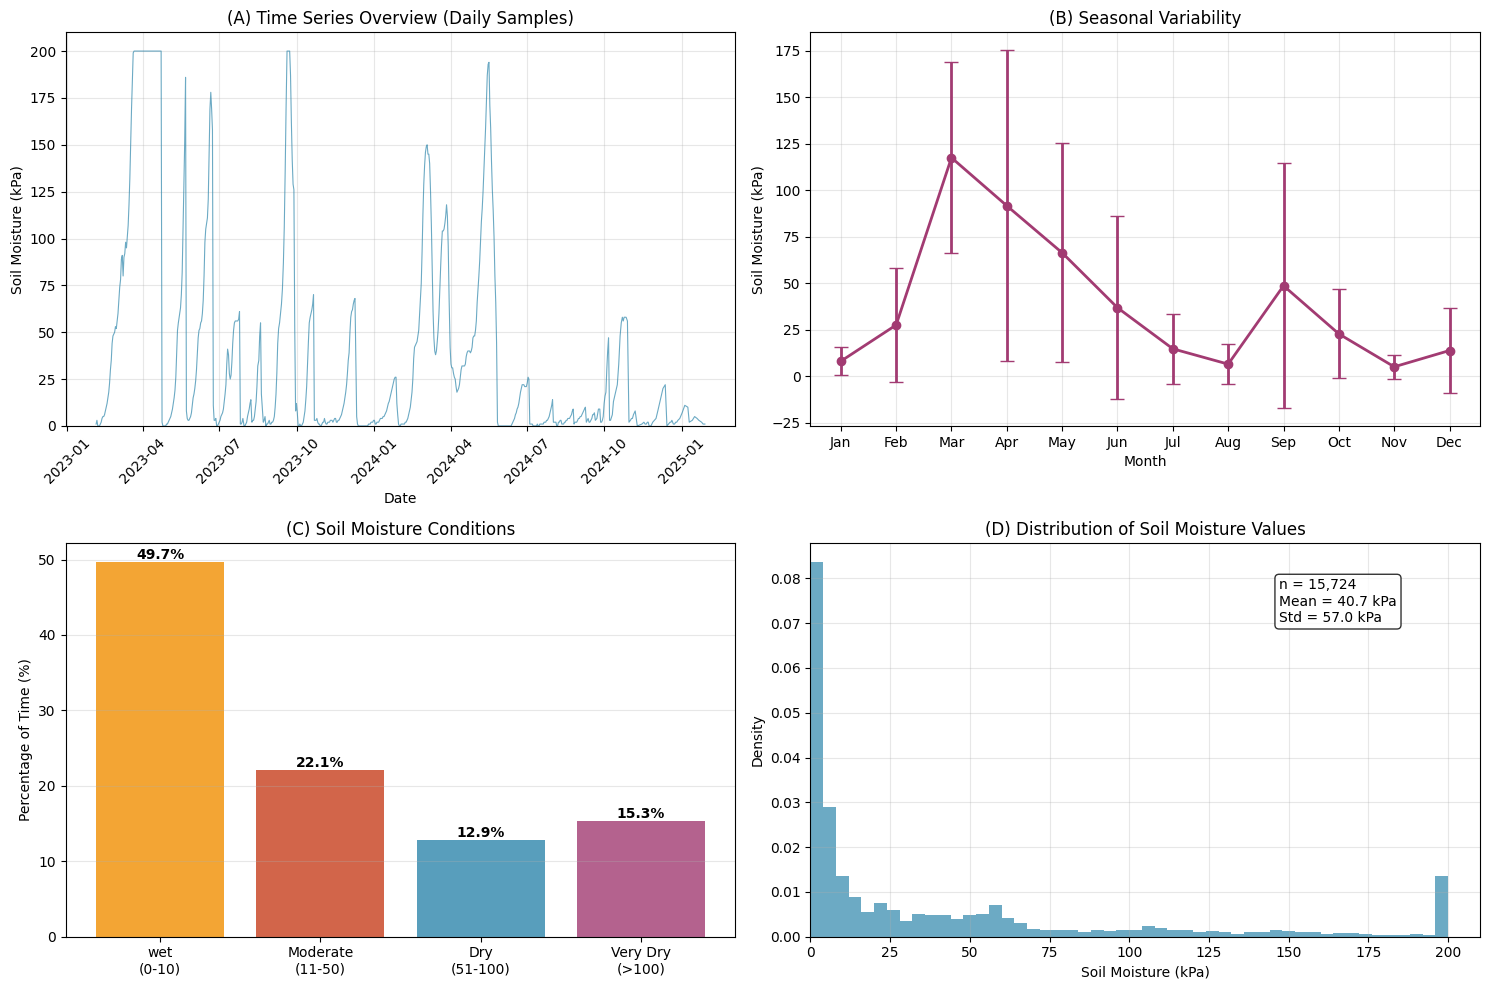

In [ ]:
def data_overview(df, target_col, save_path):
    """
    Figure 1: Dataset Overview and Temporal Patterns
    Shows the full time series, seasonal patterns, and data distribution
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Subplot A: Full time series
    ax1 = axes[0, 0]
    # Sample every 24 hours for cleaner visualization
    sample_idx = np.arange(0, len(df), 24)
    ax1.plot(df['DateTime'].iloc[sample_idx], df[target_col].iloc[sample_idx],
             color='#2E86AB', alpha=0.7, linewidth=0.8)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Soil Moisture (kPa)')
    ax1.set_ylim(0, None)
    ax1.set_title('(A) Time Series Overview (Daily Samples)')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)

    # Subplot B: Seasonal patterns
    ax2 = axes[0, 1]
    df['month'] = df['DateTime'].dt.month
    monthly_stats = df.groupby('month')[target_col].agg(['mean', 'std']).reset_index()
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    ax2.errorbar(monthly_stats['month'], monthly_stats['mean'],
                yerr=monthly_stats['std'], marker='o', capsize=5,
                color='#A23B72', linewidth=2, markersize=6)
    ax2.set_xlabel('Month')
    ax2.set_ylabel('Soil Moisture (kPa)')
    ax2.set_title('(B) Seasonal Variability')
    ax2.set_xticks(range(1, 13))
    ax2.set_xticklabels(months)
    ax2.grid(True, alpha=0.3)

    # Subplot C: Data distribution by moisture conditions
    ax3 = axes[1, 0]
    conditions = ['wet\n(0-10)', 'Moderate\n(11-50)', 'Dry\n(51-100)', 'Very Dry\n(>100)']
    percentages = [
        (df[target_col] <= 10).sum() / len(df) * 100,
        ((df[target_col] > 10) & (df[target_col] <= 50)).sum() / len(df) * 100,
        ((df[target_col] > 50) & (df[target_col] <= 100)).sum() / len(df) * 100,
        (df[target_col] > 100).sum() / len(df) * 100
    ]
    colors = ['#F18F01', '#C73E1D', '#2E86AB', '#A23B72']
    bars = ax3.bar(conditions, percentages, color=colors, alpha=0.8)
    ax3.set_ylabel('Percentage of Time (%)')
    ax3.set_title('(C) Soil Moisture Conditions')
    ax3.grid(True, alpha=0.3, axis='y')

    # Add percentage labels on bars
    for bar, pct in zip(bars, percentages):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')

    # Subplot D: Histogram with density
    ax4 = axes[1, 1]
    ax4.hist(df[target_col], bins=50, alpha=0.7, color='#2E86AB', density=True)
    ax4.set_xlabel('Soil Moisture (kPa)')
    ax4.set_xlim(0, None)
    ax4.set_ylabel('Density')
    ax4.set_title('(D) Distribution of Soil Moisture Values')
    ax4.grid(True, alpha=0.3)

    # Add statistics text
    stats_text = f'n = {len(df):,}\nMean = {df[target_col].mean():.1f} kPa\nStd = {df[target_col].std():.1f} kPa'
    ax4.text(0.7, 0.8, stats_text, transform=ax4.transAxes,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    plt.tight_layout()
    plt.savefig(f"{save_path}/Figure1_Dataset_Overview.png", dpi=300, bbox_inches='tight')
    plt.show()

data_overview(df, target, '/content/drive/MyDrive/lstm_results')

# Vanilla LSTM

In [ ]:
# --- Sequence Generation ---
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, :-1])  # all features except target
        y.append(data[i + seq_length, -1])     # target
    return np.array(X), np.array(y)

SEQ_LEN = 24  # 24-hour sequence

X_train, y_train = create_sequences(scaled_train, SEQ_LEN)
X_test, y_test = create_sequences(scaled_test, SEQ_LEN)

# --- Build and Train LSTM ---
model = Sequential([
    LSTM(64, activation='relu', input_shape=(SEQ_LEN, X_train.shape[2])),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

# --- Predict and Invert Scaling ---
y_pred_scaled = model.predict(X_test)
y_test_scaled = y_test.reshape(-1, 1)

y_pred_full = np.zeros((len(y_pred_scaled), scaled_train.shape[1]))
y_test_full = np.zeros((len(y_test_scaled), scaled_train.shape[1]))

y_pred_full[:, -1] = y_pred_scaled.flatten()
y_test_full[:, -1] = y_test_scaled.flatten()

y_pred_inv = scaler.inverse_transform(y_pred_full)[:, -1]
y_test_inv = scaler.inverse_transform(y_test_full)[:, -1]

# --- Evaluation ---
r2 = r2_score(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
nrmse = rmse / (y_test_inv.max() - y_test_inv.min())

print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"NRMSE: {nrmse:.4f}")

# --- Save to CSV ---
comparison_df = pd.DataFrame({
    "Actual_SoilMoisture_kPa": y_test_inv,
    "Predicted_SoilMoisture_kPa": y_pred_inv
})
comparison_df.to_csv("lstm_actual_vs_predicted.csv", index=False)

In [ ]:
# --- Quality Plots ---

plt.rcParams.update({
    "font.family": "serif",
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})

# Scatter Plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test_inv, y=y_pred_inv, alpha=0.5)
plt.plot([y_test_inv.min(), y_test_inv.max()], [y_test_inv.min(), y_test_inv.max()], 'r--', lw=2)
plt.xlabel("Actual Soil Moisture (kPa)")
plt.ylabel("Predicted Soil Moisture (kPa)")
plt.title("LSTM: Actual vs Predicted Soil Moisture\n(SH1 - 4in)")
plt.grid(True)
plt.tight_layout()
plt.savefig("lstm_actual_vs_predicted.png", dpi=300)
plt.savefig("lstm_actual_vs_predicted.pdf")
plt.show()

# Time Series Plot
plt.figure(figsize=(10, 4))
plt.plot(y_test_inv[:300], label="Actual", linewidth=2)
plt.plot(y_pred_inv[:300], label="Predicted", linewidth=2)
plt.xlabel("Time (hr)")
plt.ylabel("Soil Moisture (kPa)")
plt.title("First 300 hours of LSTM Soil Moisture Predictions\n(SH1 - 4in)")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.savefig("lstm_time_series_plot.png", dpi=300)
plt.savefig("lstm_time_series_plot.pdf")
plt.show()

# Seq2Seq LSTM

In [ ]:
# 1. Build Seq2Seq LSTM Model

# Custom Loss Function
def physical_loss(y_true, y_pred):
    mse = K.mean(K.square(y_true - y_pred))
    penalty = K.mean(K.maximum(-y_pred, 0.0))  # Penalize negatives
    return mse + 10.0 * penalty  # adjust factor as needed

# Sequence to Sequence LSTM
def build_seq2seq_lstm(seq_len, out_len, num_features, lstm_units=64):
    opt = Adam(learning_rate=0.001, clipnorm = 1.0) #added for longer sequences to stop exploding gradient
    model = Sequential([
        LSTM(lstm_units, activation='tanh', input_shape=(seq_len, num_features)),
        RepeatVector(out_len),
        LSTM(lstm_units, activation='tanh', return_sequences=True),
        TimeDistributed(Dense(1)),
        #TimeDistributed(Activation('softplus')) #trying to stop the model from predicting negative values but this resulted in some kind of gradient issue and Nan values being predcited.
    ])
    # model.compile(optimizer='adam', loss='mse')
    model.compile(optimizer=opt, loss=physical_loss)

    return model

# 2. Create Seq2Seq Dataset
def create_seq2seq_data(data, seq_len, out_len):
    X, y = [], []
    for i in range(len(data) - seq_len - out_len + 1):
        X.append(data[i:i + seq_len, :-1])
        y.append(data[i + seq_len:i + seq_len + out_len, -1])
    return np.array(X), np.array(y)

# 3. Forecast Plots
def plot_forecast_examples(y_test, y_pred, save_path, num_examples=5):
    random.seed(42)
    indices = random.sample(range(len(y_test)), num_examples)
    out_len = y_test.shape[1]

    plt.figure(figsize=(15, num_examples * 3))
    for i, idx in enumerate(indices):
        plt.subplot(num_examples, 1, i + 1)
        plt.plot(range(out_len), y_test[idx], label='Actual', marker='o')
        plt.plot(range(out_len), y_pred[idx], label='Predicted', marker='x')
        plt.title(f"Forecast Example {i+1}")
        plt.xlabel("Forecast Horizon (hours)")
        plt.ylabel("Soil Moisture (scaled)")
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, 'forecast_examples.png'))
    plt.close()

# 4. Forecast Horizon Error Plot
def plot_forecast_error_by_horizon(y_test, y_pred, save_path):
    out_len = y_test.shape[1]
    rmse_per_step = []
    for step in range(out_len):
        rmse = np.sqrt(mean_squared_error(y_test[:, step], y_pred[:, step]))
        rmse_per_step.append(rmse)

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, out_len + 1), rmse_per_step, marker='o')
    plt.title("Forecast RMSE Across Prediction Horizon")
    plt.xlabel("Forecast Step (Hours Ahead)")
    plt.ylabel("RMSE (scaled units)")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, 'forecast_horizon_rmse.png'))
    plt.close()

# 5. Scatter Plot
def plot_scatter(y_test_flat, y_pred_flat, save_path):
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_test_flat, y=y_pred_flat, alpha=0.5)
    plt.plot([y_test_flat.min(), y_test_flat.max()], [y_test_flat.min(), y_test_flat.max()], 'r--')
    plt.xlabel("Actual Soil Moisture (scaled)")
    plt.ylabel("Predicted Soil Moisture (scaled)")
    plt.title("Actual vs Predicted Scatter")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, 'scatter_plot.png'))
    plt.close()



# 6. Run LSTM Experiment
def run_lstm_experiment(config, scaled_train, scaled_test, num_features, master_log_path="results/master_results.csv"):
    input_seq = config["input_seq"]
    output_seq = config["output_seq"]
    lstm_units = config.get("lstm_units", 64)

    exp_name = f"lstm_in{input_seq}_out{output_seq}_units{lstm_units}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    save_dir = os.path.join("results", exp_name)
    os.makedirs(save_dir, exist_ok=True)

    # Data Prep
    X_train, y_train = create_seq2seq_data(scaled_train, input_seq, output_seq)
    X_test, y_test = create_seq2seq_data(scaled_test, input_seq, output_seq)

    # Build Model
    model = build_seq2seq_lstm(input_seq, output_seq, num_features, lstm_units)

    # Train Model
    start_time = time.time()
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        verbose=1,
        callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
    )
    elapsed_time = (time.time() - start_time) / 60

    # plot loss curve
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("LSTM Training History")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'training_history.png'))
    plt.close()

    # Predict
    y_pred = model.predict(X_test)
    y_pred_flat = y_pred.flatten()
    y_test_flat = y_test.flatten()

    # Metrics
    r2 = r2_score(y_test_flat, y_pred_flat)
    r2_adj = 1 - (1 - r2) * (len(y_test_flat) - 1) / (len(y_test_flat) - input_seq*num_features - 1)
    rmse = np.sqrt(mean_squared_error(y_test_flat, y_pred_flat))
    nrmse = rmse / (y_test_flat.max() - y_test_flat.min())
    residuals = y_test_flat - y_pred_flat


    #plot residuals
    plt.plot(residuals, label='Residuals')
    plt.xlabel("Time")
    plt.ylabel("Residuals")
    plt.title("Residuals Plot")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(save_dir, 'residuals.png'))
    plt.close()

    # Save Metrics CSV
    pd.DataFrame({
        "Actual_SoilMoisture_kPa": y_test_flat,
        "Predicted_SoilMoisture_kPa": y_pred_flat
    }).to_csv(os.path.join(save_dir, "predictions.csv"), index=False)

    # Save Evaluation Metrics
    result_row = {
        "Experiment": exp_name,
        "Input Sequence": input_seq,
        "Output Sequence": output_seq,
        "LSTM Units": lstm_units,
        "R2": r2,
        "R2 Adjusted": r2_adj,
        "RMSE": rmse,
        "NRMSE": nrmse,
        "Training Time (min)": elapsed_time
    }
    log_results(result_row, master_log_path)

    # Save Plots
    plot_forecast_examples(y_test, y_pred, save_dir)
    plot_forecast_error_by_horizon(y_test, y_pred, save_dir)
    plot_scatter(y_test_flat, y_pred_flat, save_dir)

    print(f"✅ Finished {exp_name}")
    return result_row, y_test_flat.tolist(), y_pred_flat.tolist()


# 7. Logging
def log_results(result_row, master_log_path):
    os.makedirs(os.path.dirname(master_log_path), exist_ok=True)
    if not os.path.exists(master_log_path):
        pd.DataFrame([result_row]).to_csv(master_log_path, index=False)
    else:
        existing = pd.read_csv(master_log_path)
        updated = pd.concat([existing, pd.DataFrame([result_row])], ignore_index=True)
        updated.to_csv(master_log_path, index=False)


In [ ]:
# Define your experiments here
experiment_configs = [
    {"input_seq": 24, "output_seq": 1, "lstm_units": 64},

    {"input_seq": 24, "output_seq": 24, "lstm_units": 64},
    {"input_seq": 60, "output_seq": 24, "lstm_units": 64},
    {"input_seq": 168, "output_seq": 24, "lstm_units": 64},

    {"input_seq": 168, "output_seq": 6, "lstm_units": 64},
    {"input_seq": 168, "output_seq": 12, "lstm_units": 64},
    {"input_seq": 168, "output_seq": 48, "lstm_units": 64},

    {"input_seq": 168, "output_seq": 24, "lstm_units": 32},
    {"input_seq": 168, "output_seq": 24, "lstm_units": 128},
]


# Run them all
# all_results = []
# all_actuals = []
# all_predictions = []

for config in experiment_configs:
    run_lstm_experiment(config, scaled_train, scaled_test, num_features=len(feature_cols))
    # result, y_true, y_pred =
    # all_results.append(result)
    # all_actuals.append(y_true)
    # all_predictions.append(y_pred)

## Residual Errors Plot

In [ ]:
def compute_relative_error(y_true, y_pred, epsilon=1e-6):
    return np.abs(np.array(y_pred) - np.array(y_true)) / (np.abs(y_true) + epsilon)

def get_relative_error_data(all_results, all_actuals, all_predictions):
    rel_error_data = []

    for i, result in enumerate(all_results):
        model_name = f"in{result['Input Sequence']}_out{result['Output Sequence']}"
        rel_error = compute_relative_error(all_actuals[i], all_predictions[i])

        for err in rel_error:
            rel_error_data.append({"Model": model_name, "Relative Error": err})

    return pd.DataFrame(rel_error_data)

def create_violin_plot(df_rel_error):
    plt.figure(figsize=(12, 6))
    ax = sns.violinplot(data=df_rel_error, x="Model", y="Relative Error", inner="box")
    plt.xticks(rotation=45, ha='right')
    plt.title("Relative Error Distribution Across Model Configurations")
    plt.grid(True)
    plt.tight_layout()
    return ax.get_figure()


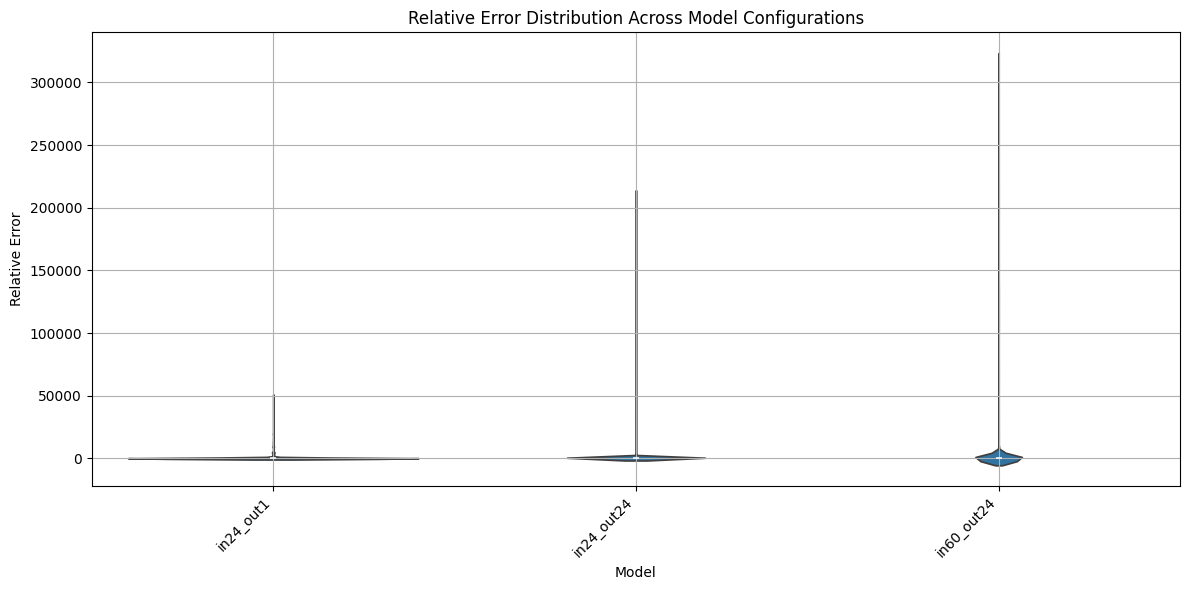

In [ ]:
df_rel_error = get_relative_error_data(all_results, all_actuals, all_predictions)
fig = create_violin_plot(df_rel_error)
fig.savefig("results/relative_error_violin.png")
plt.show()


## Save Files

In [ ]:
# prompt: download multiple files generated by scripts in colab

import zipfile
from google.colab import files
from datetime import datetime
# Correctly import the 'files' object from the google.colab module


def zip_results_directory(zip_filename="results.zip"):
  """Zips the 'results' directory for download."""
  with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files_list in os.walk("results"): # Renamed 'files' to 'files_list' to avoid conflict
      for file in files_list:
        zipf.write(os.path.join(root, file),
                   os.path.relpath(os.path.join(root, file), "results"))

  # Use the imported 'files' object for download
  files.download(zip_filename)

# Example usage after your script has run
zip_results_directory('results.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

#Option to zipfiles with the datatime
import zipfile
from google.colab import files
from datetime import datetime

def zip_results_directory():
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    folder_name = f"results_{timestamp}"
    os.rename("results", folder_name)  # Rename results folder

    zip_filename = f"{folder_name}.zip"
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files_list in os.walk(folder_name):
            for file in files_list:
                zipf.write(os.path.join(root, file),
                           os.path.relpath(os.path.join(root, file), folder_name))

    files.download(zip_filename)

zip_results_directory()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Optuna LSTM


In [ ]:
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K #added to clear GPU memory between optuna runs
import gc #added to clear GPU memory between optuna runs
from sklearn.metrics import r2_score
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_parallel_coordinate
)

# Custom Loss Function
def physical_loss(y_true, y_pred):
    mse = K.mean(K.square(y_true - y_pred))
    penalty = K.mean(K.maximum(-y_pred, 0.0))  # Penalize negatives
    return mse + 10.0 * penalty  # adjust factor as needed

def objective(trial):
    # Sample hyperparameters
    input_seq = trial.suggest_categorical("input_seq", [168])
    output_seq = trial.suggest_categorical("output_seq", [1])
    lstm_units = trial.suggest_int("lstm_units", 32, 128, step=32)
    dropout = trial.suggest_float("dropout", 0.0, 0.25)
    recurrent_dropout = trial.suggest_float("recurrent_dropout", 0.0, 0.2)
    clipnorm = trial.suggest_float("clipnorm", 0.5, 1.0)
    reg_lambda = trial.suggest_float("l2_reg", 5e-7, 1e-4, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    activation = trial.suggest_categorical("activation", ["tanh"])



    num_features = scaled_train.shape[1] - 1

    # Optimizer
    opt = Adam(learning_rate=0.001, clipnorm=clipnorm)

    # Model
    model = Sequential([
        LSTM(lstm_units, activation=activation, input_shape=(input_seq, num_features),
             dropout=dropout, recurrent_dropout=recurrent_dropout,
             kernel_regularizer=l2(reg_lambda), return_sequences=False),
        RepeatVector(output_seq),
        LSTM(lstm_units, activation=activation, return_sequences=True,
             dropout=dropout, recurrent_dropout=recurrent_dropout,
             kernel_regularizer=l2(reg_lambda)),
        TimeDistributed(Dense(1))
    ])

    model.compile(optimizer=opt, loss=physical_loss)

    # Data prep
    X_train, y_train = create_seq2seq_data(scaled_train, input_seq, output_seq)
    X_val, y_val = create_seq2seq_data(scaled_test, input_seq, output_seq)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=batch_size,
        verbose=0,
        callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
    )

    # Predict & score
    y_pred = model.predict(X_val).flatten()
    y_val_flat = y_val.flatten()

    r2 = r2_score(y_val_flat, y_pred)
    mae = np.mean(np.abs(y_val_flat - y_pred))  # Calculate MAE

    # Log individual sequence performance as user attributes
    trial.set_user_attr(f"r2_seq_{output_seq}", r2)  # Use calculated r2
    trial.set_user_attr(f"mae_seq_{output_seq}", mae)  # Use calculated mae
    trial.set_user_attr("output_seq_length", output_seq)

    # Clean up
    del model, X_train, y_train, X_val, y_val, y_pred
    K.clear_session()
    gc.collect()

    return r2 # maximize R²


In [ ]:
# Delete the existing database and start fresh
import os
if os.path.exists("lstm_optuna.db"):
    os.remove("lstm_optuna.db")

In [ ]:
#Create or load a persistent Optuna study
study = optuna.create_study(
    direction="maximize",
    study_name="lstm_study",
    #storage="sqlite:///lstm_optuna.db",
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(seed=42),  # Add this for reproducibility
    pruner=optuna.pruners.MedianPruner(n_startup_trials=10)
)

# Add error handling and periodic saves
def safe_optimize(study, objective, n_trials, batch_size=25):
    for i in range(0, n_trials, batch_size):
        current_batch = min(batch_size, n_trials - i)
        try:
            study.optimize(objective, n_trials=current_batch)
            print(f"Completed batch {i//batch_size + 1}, total trials: {len(study.trials)}")

            # Save progress
            df = study.trials_dataframe()
            df.to_csv(f"optuna_progress_batch_{i//batch_size + 1}.csv", index=False)

        except Exception as e:
            print(f"Error in batch {i//batch_size + 1}: {e}")
            break

# Usage
safe_optimize(study, objective, 30, batch_size=30)

[I 2025-06-07 23:22:54,636] A new study created in memory with name: lstm_study
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


[I 2025-06-07 23:29:41,427] Trial 0 finished with value: 0.9334213095039565 and parameters: {'input_seq': 168, 'output_seq': 1, 'lstm_units': 64, 'dropout': 0.23767857660247904, 'recurrent_dropout': 0.146398788362281, 'clipnorm': 0.7993292420985183, 'l2_reg': 1.1428087998532378e-06, 'batch_size': 64, 'activation': 'tanh'}. Best is trial 0 with value: 0.9334213095039565.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


[I 2025-06-07 23:42:05,910] Trial 1 finished with value: 0.9115962651117595 and parameters: {'input_seq': 168, 'output_seq': 1, 'lstm_units': 96, 'dropout': 0.17701814444901137, 'recurrent_dropout': 0.004116898859160489, 'clipnorm': 0.9849549260809971, 'l2_reg': 4.115716865497775e-05, 'batch_size': 16, 'activation': 'tanh'}. Best is trial 0 with value: 0.9334213095039565.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


[I 2025-06-07 23:51:01,252] Trial 2 finished with value: 0.949522703574751 and parameters: {'input_seq': 168, 'output_seq': 1, 'lstm_units': 64, 'dropout': 0.13118910790805946, 'recurrent_dropout': 0.08638900372842316, 'clipnorm': 0.645614570099021, 'l2_reg': 1.2789744480473677e-05, 'batch_size': 64, 'activation': 'tanh'}. Best is trial 2 with value: 0.949522703574751.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


[I 2025-06-08 00:02:29,736] Trial 3 finished with value: 0.9425399706857698 and parameters: {'input_seq': 168, 'output_seq': 1, 'lstm_units': 64, 'dropout': 0.1962939903482534, 'recurrent_dropout': 0.03993475643167195, 'clipnorm': 0.7571172192068059, 'l2_reg': 1.1538084020058674e-05, 'batch_size': 32, 'activation': 'tanh'}. Best is trial 2 with value: 0.949522703574751.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


[I 2025-06-08 00:14:19,837] Trial 4 finished with value: 0.909051244130499 and parameters: {'input_seq': 168, 'output_seq': 1, 'lstm_units': 32, 'dropout': 0.2372213843133333, 'recurrent_dropout': 0.19312640661491187, 'clipnorm': 0.9041986740582306, 'l2_reg': 2.5112816559973843e-06, 'batch_size': 32, 'activation': 'tanh'}. Best is trial 2 with value: 0.949522703574751.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


[I 2025-06-08 00:27:39,237] Trial 5 finished with value: 0.9542805516130929 and parameters: {'input_seq': 168, 'output_seq': 1, 'lstm_units': 32, 'dropout': 0.12379422752781755, 'recurrent_dropout': 0.006877704223043679, 'clipnorm': 0.954660201039391, 'l2_reg': 1.9698379688773633e-06, 'batch_size': 16, 'activation': 'tanh'}. Best is trial 5 with value: 0.9542805516130929.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


[I 2025-06-08 00:34:02,295] Trial 6 finished with value: 0.9306163568627484 and parameters: {'input_seq': 168, 'output_seq': 1, 'lstm_units': 96, 'dropout': 0.04621361388138176, 'recurrent_dropout': 0.19391692555291173, 'clipnorm': 0.8875664116805573, 'l2_reg': 7.257470008242942e-05, 'batch_size': 64, 'activation': 'tanh'}. Best is trial 5 with value: 0.9542805516130929.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


[I 2025-06-08 00:45:00,739] Trial 7 finished with value: 0.9635573399169705 and parameters: {'input_seq': 168, 'output_seq': 1, 'lstm_units': 32, 'dropout': 0.0489957156047863, 'recurrent_dropout': 0.009045457782107613, 'clipnorm': 0.6626651653816322, 'l2_reg': 3.920379472728674e-06, 'batch_size': 32, 'activation': 'tanh'}. Best is trial 7 with value: 0.9635573399169705.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


[I 2025-06-08 01:00:20,769] Trial 8 finished with value: 0.951900721028264 and parameters: {'input_seq': 168, 'output_seq': 1, 'lstm_units': 64, 'dropout': 0.13567402078956212, 'recurrent_dropout': 0.02818484499495253, 'clipnorm': 0.9010984903770198, 'l2_reg': 7.42186877939516e-07, 'batch_size': 16, 'activation': 'tanh'}. Best is trial 7 with value: 0.9635573399169705.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


[I 2025-06-08 01:10:23,628] Trial 9 finished with value: 0.8918706196722611 and parameters: {'input_seq': 168, 'output_seq': 1, 'lstm_units': 32, 'dropout': 0.20386535711370854, 'recurrent_dropout': 0.14137146876952342, 'clipnorm': 0.8645035840204937, 'l2_reg': 2.9763651229119868e-05, 'batch_size': 32, 'activation': 'tanh'}. Best is trial 7 with value: 0.9635573399169705.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


[I 2025-06-08 01:22:56,957] Trial 10 finished with value: 0.9748295114012381 and parameters: {'input_seq': 168, 'output_seq': 1, 'lstm_units': 128, 'dropout': 0.0014992957389542982, 'recurrent_dropout': 0.07374575454421946, 'clipnorm': 0.5089809378074097, 'l2_reg': 4.638015946104551e-06, 'batch_size': 32, 'activation': 'tanh'}. Best is trial 10 with value: 0.9748295114012381.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


[I 2025-06-08 01:35:18,345] Trial 11 finished with value: 0.9682036021786431 and parameters: {'input_seq': 168, 'output_seq': 1, 'lstm_units': 128, 'dropout': 0.0031061401157658278, 'recurrent_dropout': 0.0739560701219745, 'clipnorm': 0.5022887228345516, 'l2_reg': 4.4644886404418425e-06, 'batch_size': 32, 'activation': 'tanh'}. Best is trial 10 with value: 0.9748295114012381.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


[I 2025-06-08 01:47:24,831] Trial 12 finished with value: 0.9713545890695414 and parameters: {'input_seq': 168, 'output_seq': 1, 'lstm_units': 128, 'dropout': 0.008137470163966355, 'recurrent_dropout': 0.08158374684317826, 'clipnorm': 0.5053301449493504, 'l2_reg': 5.856574767987487e-06, 'batch_size': 32, 'activation': 'tanh'}. Best is trial 10 with value: 0.9748295114012381.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


[I 2025-06-08 01:59:10,357] Trial 13 finished with value: 0.9616904544453283 and parameters: {'input_seq': 168, 'output_seq': 1, 'lstm_units': 128, 'dropout': 0.0016411588863850688, 'recurrent_dropout': 0.11366467512903734, 'clipnorm': 0.5034467824161368, 'l2_reg': 8.489076981455828e-06, 'batch_size': 32, 'activation': 'tanh'}. Best is trial 10 with value: 0.9748295114012381.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


[I 2025-06-08 02:17:08,855] Trial 14 finished with value: 0.9624938586535922 and parameters: {'input_seq': 168, 'output_seq': 1, 'lstm_units': 128, 'dropout': 0.05622531929193502, 'recurrent_dropout': 0.057391291688501794, 'clipnorm': 0.5745571340352766, 'l2_reg': 1.573899129180051e-05, 'batch_size': 32, 'activation': 'tanh'}. Best is trial 10 with value: 0.9748295114012381.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


[I 2025-06-08 02:34:03,510] Trial 15 finished with value: 0.9637000784622769 and parameters: {'input_seq': 168, 'output_seq': 1, 'lstm_units': 96, 'dropout': 0.08564620021782893, 'recurrent_dropout': 0.11431024609793916, 'clipnorm': 0.5936178559861194, 'l2_reg': 5.173082263247373e-06, 'batch_size': 32, 'activation': 'tanh'}. Best is trial 10 with value: 0.9748295114012381.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


[I 2025-06-08 02:44:19,288] Trial 16 finished with value: 0.9485476860989821 and parameters: {'input_seq': 168, 'output_seq': 1, 'lstm_units': 128, 'dropout': 0.026011232448301384, 'recurrent_dropout': 0.053680900752100066, 'clipnorm': 0.5656868512994225, 'l2_reg': 1.6723881637918776e-06, 'batch_size': 32, 'activation': 'tanh'}. Best is trial 10 with value: 0.9748295114012381.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


[I 2025-06-08 02:59:36,902] Trial 17 finished with value: 0.9650413709984301 and parameters: {'input_seq': 168, 'output_seq': 1, 'lstm_units': 96, 'dropout': 0.085035671368897, 'recurrent_dropout': 0.09446439233344028, 'clipnorm': 0.6807859342063625, 'l2_reg': 2.32464995715652e-05, 'batch_size': 32, 'activation': 'tanh'}. Best is trial 10 with value: 0.9748295114012381.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


[I 2025-06-08 03:06:15,851] Trial 18 finished with value: 0.9645324750659046 and parameters: {'input_seq': 168, 'output_seq': 1, 'lstm_units': 128, 'dropout': 0.08788041453330292, 'recurrent_dropout': 0.13836367477421022, 'clipnorm': 0.5453436840106068, 'l2_reg': 5.428250218889648e-07, 'batch_size': 64, 'activation': 'tanh'}. Best is trial 10 with value: 0.9748295114012381.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


[I 2025-06-08 03:24:56,778] Trial 19 finished with value: 0.9726999855876969 and parameters: {'input_seq': 168, 'output_seq': 1, 'lstm_units': 128, 'dropout': 0.02405288565070033, 'recurrent_dropout': 0.07217582411931908, 'clipnorm': 0.7177343251658945, 'l2_reg': 6.4161684839174305e-06, 'batch_size': 16, 'activation': 'tanh'}. Best is trial 10 with value: 0.9748295114012381.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


[I 2025-06-08 03:48:12,728] Trial 20 finished with value: 0.9774247021088854 and parameters: {'input_seq': 168, 'output_seq': 1, 'lstm_units': 96, 'dropout': 0.02421745717723411, 'recurrent_dropout': 0.06269163649497403, 'clipnorm': 0.7267402957992132, 'l2_reg': 2.277254605467395e-06, 'batch_size': 16, 'activation': 'tanh'}. Best is trial 20 with value: 0.9774247021088854.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


[I 2025-06-08 04:14:16,140] Trial 21 finished with value: 0.9755553171332767 and parameters: {'input_seq': 168, 'output_seq': 1, 'lstm_units': 96, 'dropout': 0.02882471074934161, 'recurrent_dropout': 0.06549811752856419, 'clipnorm': 0.722359621771502, 'l2_reg': 3.876046068690801e-06, 'batch_size': 16, 'activation': 'tanh'}. Best is trial 20 with value: 0.9774247021088854.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


[I 2025-06-08 04:44:29,941] Trial 22 finished with value: 0.9732072659136531 and parameters: {'input_seq': 168, 'output_seq': 1, 'lstm_units': 96, 'dropout': 0.03306822125193496, 'recurrent_dropout': 0.056794711194178595, 'clipnorm': 0.7643901130926254, 'l2_reg': 3.1371326772209674e-06, 'batch_size': 16, 'activation': 'tanh'}. Best is trial 20 with value: 0.9774247021088854.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


[I 2025-06-08 04:59:50,367] Trial 23 finished with value: 0.9562141854442742 and parameters: {'input_seq': 168, 'output_seq': 1, 'lstm_units': 96, 'dropout': 0.06798785936777275, 'recurrent_dropout': 0.03177022207915894, 'clipnorm': 0.807564207387196, 'l2_reg': 9.505243893649713e-07, 'batch_size': 16, 'activation': 'tanh'}. Best is trial 20 with value: 0.9774247021088854.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


[I 2025-06-08 05:22:44,340] Trial 24 finished with value: 0.9633112542970217 and parameters: {'input_seq': 168, 'output_seq': 1, 'lstm_units': 96, 'dropout': 0.1079895078388369, 'recurrent_dropout': 0.10842068588157411, 'clipnorm': 0.6255912683237167, 'l2_reg': 1.4935769445137257e-06, 'batch_size': 16, 'activation': 'tanh'}. Best is trial 20 with value: 0.9774247021088854.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


[I 2025-06-08 05:41:01,083] Trial 25 finished with value: 0.9775378458475883 and parameters: {'input_seq': 168, 'output_seq': 1, 'lstm_units': 96, 'dropout': 0.025287869745135076, 'recurrent_dropout': 0.06552730537877988, 'clipnorm': 0.7077185262675034, 'l2_reg': 2.6242997209891954e-06, 'batch_size': 16, 'activation': 'tanh'}. Best is trial 25 with value: 0.9775378458475883.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


[I 2025-06-08 05:56:36,213] Trial 26 finished with value: 0.9666395910270554 and parameters: {'input_seq': 168, 'output_seq': 1, 'lstm_units': 96, 'dropout': 0.06580848751131066, 'recurrent_dropout': 0.04117782112942256, 'clipnorm': 0.7081399304509315, 'l2_reg': 2.680289666700736e-06, 'batch_size': 16, 'activation': 'tanh'}. Best is trial 25 with value: 0.9775378458475883.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


[I 2025-06-08 06:08:26,370] Trial 27 finished with value: 0.9448705814133561 and parameters: {'input_seq': 168, 'output_seq': 1, 'lstm_units': 64, 'dropout': 0.03734227240226603, 'recurrent_dropout': 0.06187278324894587, 'clipnorm': 0.8067912073775371, 'l2_reg': 2.2286395285699206e-06, 'batch_size': 16, 'activation': 'tanh'}. Best is trial 25 with value: 0.9775378458475883.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


[I 2025-06-08 06:32:24,140] Trial 28 finished with value: 0.9753918442039966 and parameters: {'input_seq': 168, 'output_seq': 1, 'lstm_units': 96, 'dropout': 0.01874957859256069, 'recurrent_dropout': 0.01759277681912841, 'clipnorm': 0.719277375478613, 'l2_reg': 1.3262166849056587e-06, 'batch_size': 16, 'activation': 'tanh'}. Best is trial 25 with value: 0.9775378458475883.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2025-06-08 06:44:54,935] Trial 29 finished with value: 0.9491373277961448 and parameters: {'input_seq': 168, 'output_seq': 1, 'lstm_units': 64, 'dropout': 0.1553226009208798, 'recurrent_dropout': 0.162683491511798, 'clipnorm': 0.8336799358127267, 'l2_reg': 1.062621026798761e-06, 'batch_size': 16, 'activation': 'tanh'}. Best is trial 25 with value: 0.9775378458475883.


Completed batch 1, total trials: 30


In [ ]:
#Analyze results
def analyze_optuna_study(study, save_dir="optuna_analysis"):
    import os
    os.makedirs(save_dir, exist_ok=True)

    # Save trials
    df = study.trials_dataframe()
    df.to_csv(os.path.join(save_dir, "optuna_trials.csv"), index=False)

    # Print best trial
    best = study.best_trial
    print(f"\n🏆 Best Trial (R² = {best.value:.4f}):")
    for k, v in best.params.items():
        print(f"  {k}: {v}")

    # Save interactive plots
    plot_optimization_history(study).write_html(os.path.join(save_dir, "optimization_history.html"))
    plot_param_importances(study).write_html(os.path.join(save_dir, "param_importances.html"))
    plot_parallel_coordinate(study).write_html(os.path.join(save_dir, "parallel_coordinates.html"))

    print(f"\n✅ All analysis saved to: {save_dir}")
    return df

#Call after training
analyze_optuna_study(study)


🏆 Best Trial (R² = 0.8475):
  input_seq: 168
  output_seq: 24
  lstm_units: 64
  dropout: 0.14836996908684905
  recurrent_dropout: 0.03760564726438797
  clipnorm: 0.6183049463585949
  l2_reg: 1.1377156746085367e-06
  batch_size: 16
  activation: tanh

✅ All analysis saved to: optuna_analysis


,number,value,datetime_start,datetime_complete,duration,params_activation,params_batch_size,params_clipnorm,params_dropout,params_input_seq,params_l2_reg,params_lstm_units,params_output_seq,params_recurrent_dropout,user_attrs_mae_seq_24,user_attrs_output_seq_length,user_attrs_r2_seq_24,state
0,0,0.831660,2025-06-06 13:56:57.789213,2025-06-06 14:03:48.307236,0 days 00:06:50.518023,tanh,64,0.799329,0.237679,168,1.142809e-06,64,24,0.146399,0.016732,24,0.831660,COMPLETE
1,1,0.819514,2025-06-06 14:03:48.326701,2025-06-06 14:27:09.777345,0 days 00:23:21.450644,tanh,16,0.984955,0.177018,168,4.115717e-05,96,24,0.004117,0.016929,24,0.819514,COMPLETE
2,2,0.817552,2025-06-06 14:27:09.794313,2025-06-06 14:33:52.335434,0 days 00:06:42.541121,tanh,64,0.645615,0.131189,168,1.278974e-05,64,24,0.086389,0.016024,24,0.817552,COMPLETE
3,3,0.816616,2025-06-06 14:33:52.350720,2025-06-06 14:46:45.318696,0 days 00:12:52.967976,tanh,32,0.757117,0.196294,168,1.153808e-05,64,24,0.039935,0.016934,24,0.816616,COMPLETE
4,4,0.796898,2025-06-06 14:46:45.334819,2025-06-06 14:56:15.859654,0 days 00:09:30.524835,tanh,32,0.904199,0.237221,168,2.511282e-06,32,24,0.193126,0.020654,24,0.796898,COMPLETE
5,5,0.772127,2025-06-06 14:56:15.877694,2025-06-06 15:06:46.680800,0 days 00:10:30.803106,tanh,16,0.954660,0.123794,168,1.969838e-06,32,24,0.006878,0.019933,24,0.772127,COMPLETE
6,6,0.786383,2025-06-06 15:06:46.697691,2025-06-06 15:17:44.526078,0 days 00:10:57.828387,tanh,64,0.887566,0.046214,168,7.257470e-05,96,24,0.193917,0.016529,24,0.786383,COMPLETE
7,7,0.790307,2025-06-06 15:17:44.541631,2025-06-06 15:28:06.882072,0 days 00:10:22.340441,tanh,32,0.662665,0.048996,168,3.920379e-06,32,24,0.009045,0.016265,24,0.790307,COMPLETE
8,8,0.835794,2025-06-06 15:28:06.898220,2025-06-06 15:47:34.997768,0 days 00:19:28.099548,tanh,16,0.901098,0.135674,168,7.421869e-07,64,24,0.028185,0.016046,24,0.835794,COMPLETE
9,9,0.752764,2025-06-06 15:47:35.015482,2025-06-06 15:55:02.460900,0 days 00:07:27.445418,tanh,32,0.864504,0.203865,168,2.976365e-05,32,24,0.141371,0.026009,24,0.752764,COMPLETE


In [ ]:
def analyze_optuna_study(study, save_dir="optuna_analysis"):
    import os
    import pandas as pd
    os.makedirs(save_dir, exist_ok=True)

    df = study.trials_dataframe()
    df.to_csv(os.path.join(save_dir, "optuna_trials.csv"), index=False)

    # Analyze by output sequence length
    seq_analysis = {}
    for seq_len in [6, 12, 24]:
        seq_trials = [t for t in study.trials if t.user_attrs.get("output_seq_length") == seq_len]
        if seq_trials:
            best_seq = max(seq_trials, key=lambda x: x.value)
            seq_analysis[seq_len] = {
                'best_r2': best_seq.value,
                'best_params': best_seq.params,
                'trial_count': len(seq_trials)
            }

    # Print stratified results
    print("\n📊 Performance by Output Sequence Length:")
    for seq_len, data in seq_analysis.items():
        print(f"  {seq_len}h - Best R²: {data['best_r2']:.4f} ({data['trial_count']} trials)")

    # Save stratified analysis
    with open(os.path.join(save_dir, "sequence_analysis.txt"), "w") as f:
        for seq_len, data in seq_analysis.items():
            f.write(f"\n{seq_len}-hour predictions:\n")
            f.write(f"Best R²: {data['best_r2']:.4f}\n")
            f.write("Best parameters:\n")
            for k, v in data['best_params'].items():
                f.write(f"  {k}: {v}\n")

    # Your existing plotting code...
    return df, seq_analysis

#Call after training
analyze_optuna_study(study)

# Optimized LSTM

In [ ]:
# Set publication-quality style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    'font.family': 'serif'
})

# Build Seq2Seq LSTM Model

# Custom Loss Function
def physical_loss(y_test, y_pred):
    mse = K.mean(K.square(y_test - y_pred))
    penalty = K.mean(K.maximum(-y_pred, 0.0))  # Penalize negatives
    return mse + 10.0 * penalty  # adjust factor as needed
#returns the sum of the calculated MSE and the penalty term, multiplied by a factor of 10.0.
#By adding this penalty to the standard MSE, the loss function encourages the model to avoid predicting negative soil moisture values, which are not physically possible. This incorporates domain knowledge into the training process.
#The factor of 10.0 determines the weight given to the penalty term. A higher value means the model will be more strongly penalized for predicting negative values. You can adjust this factor as needed to find a balance.

def set_seeds(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)


# Sequence to Sequence LSTM
def build_seq2seq_lstm(seq_len, out_len, num_features,
                       lstm_units=64,
                       activation='tanh',
                       dropout=0.2,
                       recurrent_dropout=0.2,
                       l2_reg=0.0,
                       clipnorm=None,
                       batch_size=16,
                       learning_rate=0.001):

    model = Sequential([
        Input(shape=(seq_len, num_features)),
        LSTM(
            lstm_units,
            activation=activation,
            kernel_initializer='glorot_uniform',  # This is for consistent initialisation
            recurrent_initializer='orthogonal',   # Add this
            bias_initializer='zeros',             # Add this
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            kernel_regularizer=l2(l2_reg)
        ),
        RepeatVector(out_len),
        LSTM(
            lstm_units,
            activation=activation,
            return_sequences=True,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            kernel_regularizer=l2(l2_reg)
        ),
        TimeDistributed(Dense(1, activation='relu'))  # Ensures non-negative output
    ])

    opt = Adam(learning_rate=learning_rate)
    if clipnorm is not None:
        opt.clipnorm = clipnorm

    model.compile(optimizer=opt, loss=physical_loss)

    return model

# Create Seq2Seq Dataset
def create_seq2seq_data(data, seq_len, out_len):
    X, y = [], []
    for i in range(len(data) - seq_len - out_len + 1):
        X.append(data[i:i + seq_len, :-1])
        y.append(data[i + seq_len:i + seq_len + out_len, -1])
    return np.array(X), np.array(y)


# Forecast Plots
# Forecast Horizon Error Plot
def plot_forecast_error_by_horizon(y_test_original, y_pred_original, save_path):
    out_len = y_test_original.shape[1]
    rmse_per_step = []
    for step in range(out_len):
        rmse = np.sqrt(mean_squared_error(y_test_original[:, step], y_pred_original[:, step]))
        rmse_per_step.append(rmse)

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, out_len + 1), rmse_per_step, marker='o')
    plt.title("Forecast RMSE Across Prediction Horizon")
    plt.xlabel("Forecast Step (Hours Ahead)")
    plt.ylabel("RMSE")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, 'forecast_horizon_rmse.png'))
    plt.close()


# Scatter Plot Unscaled
def plot_scatter_unscaled(y_test_original, y_pred_original, save_path):
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=y_test_original, y=y_pred_original, alpha=0.6, size=0.1)

    # Perfect prediction line
    min_val, max_val = min(y_test_original.min(), y_pred_original.min()), \
                       max(y_test_original.max(), y_pred_original.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')

    plt.xlabel("Actual Soil Moisture (kPa)")
    plt.ylabel("Predicted Soil Moisture (kPa)")
    plt.title("Actual vs Predicted Soil Moisture")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Add R² annotation
    r2 = r2_score(y_test_original, y_pred_original)
    plt.text(0.05, 0.95, f'R² = {r2:.3f}', transform=plt.gca().transAxes,
             bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))

    plt.tight_layout()
    plt.savefig(os.path.join(save_path, 'scatter_plot_kPa.png'), dpi=300)
    plt.show()

# Time Series Sample
def plot_time_series_full(y_test_original, y_pred_original, output_seq, save_path):
    """Plot the entire test dataset time series"""

    plt.figure(figsize=(20, 8))

    # Plot entire dataset
    #start_idx = input_seq
    #end_idx = start_idx + len(y_test_original)
    #dates = df['DateTime'].iloc[start_idx:end_idx]

    plt.plot(y_test_original, 'b-', label='Actual', linewidth=1, alpha=0.8)
    plt.plot(y_pred_original, 'r-', label='Predicted', linewidth=1, alpha=0.8)

    plt.xlabel("Hours")
    plt.ylabel("Soil Moisture (kPa)")
    #plt.ylim(0, None)
    plt.title("Soil Moisture Prediction - Full Test Dataset")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Add week markers (every 7 days = 168 hours)
    for week in range(0, len(y_test_original), 168):
        plt.axvline(x=week, color='gray', alpha=0.3, linestyle=':', linewidth=0.8)

    plt.tight_layout()
    plt.savefig(os.path.join(save_path, 'time_series_full_dataset_kPa.png'), dpi=300, bbox_inches='tight')
    plt.show()

def plot_time_series_single(y_test_original, y_pred_original, output_seq, save_path):
    """Plot the entire test dataset time series"""

    plt.figure(figsize=(20, 8))

    # Plot entire dataset
    #start_idx = input_seq
    #end_idx = start_idx + len(y_test_original)
    #dates = df['DateTime'].iloc[start_idx:end_idx]

    # Take only the first predicted hour from each sequence to avoid overlap
    single_predictions = []
    num_sequences = len(y_test_original) // output_seq
    for i in range(num_sequences):
        single_predictions.append(y_pred_original[i][0])  # First hour only

    plt.plot(single_predictions, 'r-', label='Predicted', linewidth=1, alpha=0.8)
    plt.plot(y_test_original, 'b-', label='Actual', linewidth=1, alpha=0.8)
    plt.xlabel("Hours")
    plt.ylabel("Soil Moisture (kPa)")
    #plt.ylim(0, None)
    plt.title("Soil Moisture Prediction - Full Test Dataset")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Add week markers (every 7 days = 168 hours)
    for week in range(0, len(y_test_original), 168):
        plt.axvline(x=week, color='gray', alpha=0.3, linestyle=':', linewidth=0.8)

    plt.tight_layout()
    plt.savefig(os.path.join(save_path, 'time_series_single_dataset_kPa.png'), dpi=300, bbox_inches='tight')
    plt.show()


# Calculate Unscaled Metrics
def calculate_real_metrics(y_test_original, y_pred_original, save_path):
    """Calculate metrics in original kPa units"""

    r2 = r2_score(y_test_original, y_pred_original)
    mae_kPa = np.mean(np.abs(y_test_original - y_pred_original))
    rmse_kPa = np.sqrt(np.mean((y_test_original - y_pred_original)**2))
    epsilon = 1e-8
    mape = np.mean(np.abs((y_test_original - y_pred_original) / (y_test_original + epsilon))) * 100

    # Additional context metrics
    data_range_kPa = y_test_original.max() - y_test_original.min()
    rmse_percent = (rmse_kPa / data_range_kPa) * 100

    print(f"📊 Model Performance in Original Units:")
    print(f"R² Score: {r2:.3f}")
    print(f"MAE: {mae_kPa:.2f} kPa")
    print(f"RMSE: {rmse_kPa:.2f} kPa ({rmse_percent:.1f}% of data range)")
    print(f"MAPE: {mape:.1f}%")
    print(f"Data Range: {y_test_original.min():.1f} - {y_test_original.max():.1f} kPa")

    # CREATE AND SAVE CSV
    metrics_df = pd.DataFrame({
    'Metric': ['R2_Score', 'MAE_kPa', 'RMSE_kPa', 'MAPE_percent', 'Data_Range_kPa'],
    'Value': [r2, mae_kPa, rmse_kPa, mape, data_range_kPa]
    })
    metrics_df.to_csv(os.path.join(save_path, 'overall_metrics.csv'), index=False)

    return {
        'R2': r2, 'MAE_kPa': mae_kPa, 'RMSE_kPa': rmse_kPa,
        'MAPE': mape, 'Data_Range_kPa': data_range_kPa
    }

# Evaluate model by moisture conditions
def evaluate_by_conditions(y_test_original, y_pred_original, save_path):
    print("🌱 SOIL MOISTURE ANALYSIS:")
    conditions = [
        ("Wet/Saturated (0-10 kPa)", y_test_original <= 10),      # WET
        ("Moist (11-50 kPa)", (y_test_original > 10) & (y_test_original <= 50)),   # Still moist
        ("Dry (51-100 kPa)", (y_test_original > 50) & (y_test_original <= 100)),   # Getting dry
        ("Very Dry (>100 kPa)", y_test_original > 100)           # Very dry, approaching stress
    ]

    # Store results for CSV
    condition_results = []

    print("🌱 SOIL MOISTURE ANALYSIS:")
    for name, mask in conditions:
        if mask.sum() > 0:
            r2 = r2_score(y_test_original[mask], y_pred_original[mask])
            mae = np.mean(np.abs(y_test_original[mask] - y_pred_original[mask]))
            n_samples = mask.sum()

            print(f"  {name}: R²={r2:.3f}, MAE={mae:.1f} kPa ({n_samples} samples)")

            # ADD TO RESULTS LIST
            condition_results.append({
                'Condition': name,
                'R2_Score': r2,
                'MAE_kPa': mae,
                'Sample_Count': n_samples
            })

    # SAVE TO CSV
    if condition_results:
        conditions_df = pd.DataFrame(condition_results)
        conditions_df.to_csv(os.path.join(save_path, 'conditions_analysis.csv'), index=False)

    return condition_results



# Run LSTM Experiment
def run_lstm_experiment(config, scaled_train, scaled_test, num_features,
                       df_v2, target_col, scaler, feature_cols,
                       master_log_path="/content/drive/MyDrive/lstm_results/master_results.csv"):
    input_seq = config["input_seq"]
    output_seq = config["output_seq"]
    lstm_units = config.get("lstm_units", 64)

    exp_name = f"lstm_in{input_seq}_out{output_seq}_units{lstm_units}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    save_dir = os.path.join("/content/drive/MyDrive/lstm_results", exp_name)
    os.makedirs(save_dir, exist_ok=True)

    # Data Prep
    X_train, y_train = create_seq2seq_data(scaled_train, input_seq, output_seq)
    X_test, y_test = create_seq2seq_data(scaled_test, input_seq, output_seq)

    # Build Model
    model = build_seq2seq_lstm(
    seq_len=input_seq,
    out_len=output_seq,
    num_features=num_features,
    lstm_units=config.get("lstm_units", 64),
    activation=config.get("activation", "tanh"),
    dropout=config.get("dropout", 0.2),
    recurrent_dropout=config.get("recurrent_dropout", 0.2),
    l2_reg=config.get("l2_reg", 0.0),
    clipnorm=config.get("clipnorm", None),
    learning_rate=config.get("learning_rate", 0.001)
    )

    batch_size = config.get("batch_size", 16)

    # Train Model
    start_time = time.time()
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=batch_size,
        validation_split=0.2,
        verbose=1,
        callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
    )
    elapsed_time = (time.time() - start_time) / 60

    # plot loss curve
    plt.plot(history.history['loss'], label='Training Loss')
    #plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("LSTM Training History")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'training_history.png'))
    plt.close()

    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Val Loss")
    plt.title("LSTM Training History")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'training_history_val.png'))
    plt.close()

    # Predict
    y_pred = model.predict(X_test)
    y_pred_flat = y_pred.flatten()
    y_test_flat = y_test.flatten()

    #unscale the data
    y_test_original = target_scaler.inverse_transform(y_test_flat.reshape(-1, 1)).flatten()
    y_pred_original = target_scaler.inverse_transform(y_pred_flat.reshape(-1, 1)).flatten()

    #plot residuals
    # Simple approach - get dates starting from input_seq
    #start_idx = input_seq
    #end_idx = start_idx + len(y_test_original)
    #dates = df_test['DateTime'].iloc[start_idx:end_idx]

    residuals = y_test_original - y_pred_original
    #plt.plot(residuals, label='Residuals')
    #plt.xlabel("Time")
    #plt.ylabel("Residuals")
    #plt.title("Residuals Plot")
    #plt.legend()
    #plt.grid(True)
    #plt.savefig(os.path.join(save_dir, 'residuals.png'))
    #plt.close()

    # Save Predictions CSV
    pd.DataFrame({
        "Actual_SoilMoisture_kPa": y_test_flat,
        "Predicted_SoilMoisture_kPa": y_pred_flat
    }).to_csv(os.path.join(save_dir, "predictions_scaled.csv"), index=False)

    pd.DataFrame({
        "Actual_SoilMoisture_kPa": y_test_original,
        "Predicted_SoilMoisture_kPa": y_pred_original
    }).to_csv(os.path.join(save_dir, "predictions_kPa.csv"), index=False)

    # Calculate all metrics using consistent arrays
    r2 = r2_score(y_test_original, y_pred_original)
    mae = np.mean(np.abs(y_test_original - y_pred_original))
    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    nrmse = rmse / (y_test_original.max() - y_test_original.min())
    epsilon = 1e-8  # Small number to avoid division by zero
    mape = np.mean(np.abs((y_test_original - y_pred_original) / (y_test_original + epsilon))) * 100
    r2_adj = 1 - (1 - r2) * (len(y_test_original) - 1) / (len(y_test_original) - input_seq*num_features - 1)

    result_row = {
        "Experiment": exp_name,
        "Input Sequence": input_seq,
        "Output Sequence": output_seq,
        "LSTM Units": lstm_units,
        "R2": r2,
        "R2 Adjusted": r2_adj,
        "MAE": mae,
        "RMSE": rmse,
        "NRMSE": nrmse,
        "MAPE": mape,
        "Batch Size": batch_size,
        "Data Range": f"{y_test_original.min():.1f} - {y_test_original.max():.1f} kPa",
        "Training Time (min)": elapsed_time
    }
    log_results(result_row, master_log_path)

    calculate_real_metrics(y_test_original, y_pred_original, save_dir)
    evaluate_by_conditions(y_test_original, y_pred_original, save_dir)

    # Save Plots
    #plot_scatter(y_test_flat, y_pred_flat, save_dir)
    plot_scatter_unscaled(y_test_original, y_pred_original, save_dir)
    #plot_time_series_sample(y_test_original, y_pred_original, save_dir, sample_length=48)
    plot_time_series_full(y_test_original, y_pred_original, output_seq, save_dir)
    #relative_error(y_test_original, y_pred_original, save_dir)
    #perf_moisture_condition(y_test_original, y_pred_original, save_dir)
    #forecast_examples(y_test_original, y_pred_original, save_dir, output_seq=48)

    # Reshape back to 2D for plotting functions
    num_samples = len(y_test_flat) // output_seq
    y_test_original = y_test_original.reshape(num_samples, output_seq)
    y_pred_original = y_pred_original.reshape(num_samples, output_seq)


    # Save Plots
    #plot_forecast_examples(y_test_original, y_pred_original, save_dir)
    plot_forecast_error_by_horizon(y_test_original, y_pred_original, save_dir)
    plot_time_series_single(y_test_original, y_pred_original, output_seq, save_dir)

    print(f"✅ Finished {exp_name}")
    return result_row, y_test_flat.tolist(), y_pred_flat.tolist(), y_test_flat, y_pred_flat, y_test_original, y_pred_original


# 7. Logging
def log_results(result_row, master_log_path):
    os.makedirs(os.path.dirname(master_log_path), exist_ok=True)
    if not os.path.exists(master_log_path):
        pd.DataFrame([result_row]).to_csv(master_log_path, index=False)
    else:
        existing = pd.read_csv(master_log_path)
        updated = pd.concat([existing, pd.DataFrame([result_row])], ignore_index=True)
        updated.to_csv(master_log_path, index=False)


In [ ]:
best_config = {
    "input_seq": 168,
    "output_seq": 6,
    "lstm_units": 64,
    "batch_size": 16,
    "activation": "tanh",
    "dropout": 0.05083,
    "recurrent_dropout": 0.04739,
    "clipnorm": 1.144627,
    "l2_reg": 1.92572e-05,
    "learning_rate": 0.0005 #reduced from 0.001 to get better performance
}

In [ ]:
best_config = {
    "input_seq": 168,
    "output_seq": 12,
    "lstm_units": 64,
    "batch_size": 16,
    "activation": "tanh",
    "dropout": 0.05148,
    "recurrent_dropout": 0.042785,
    "clipnorm": 0.6419,
    "l2_reg": 2.987721e-06,
    "learning_rate": 0.0005 #reduced from 0.001 to get better performance
}

In [ ]:
best_config = {
    "input_seq": 168,
    "output_seq": 24,
    "lstm_units": 64,
    "batch_size": 16,
    "activation": "tanh",
    "dropout": 0.1483699,
    "recurrent_dropout": 0.0376056,
    "clipnorm": 0.6183049,
    "l2_reg": 1.1377156e-06,
    "learning_rate": 0.0005 #reduced from 0.001 to get better performance
}

In [ ]:
best_config = {
    "input_seq": 168,
    "output_seq": 1,
    "lstm_units": 64,
    "batch_size": 16,
    "activation": "tanh",
    "dropout": 0.02528786,
    "recurrent_dropout": 0.0655273,
    "clipnorm": 0.70771852,
    "l2_reg": 2.62429972e-06,
    "learning_rate": 0.0005 #reduced from 0.001 to get better performance
}

In [ ]:
best_config = {
    "input_seq": 168,
    "output_seq": 48,
    "lstm_units": 64,
    "batch_size": 16,
    "activation": "tanh",
    "dropout": 0.12796689,
    "recurrent_dropout": 0.07202147,
    "clipnorm": 0.6290516,
    "l2_reg": 5.4363633e-07,
    "learning_rate": 0.00005 #reduced from 0.001 to get better performance
}

Epoch 1/50
614/614 ━━━━━━━━━━━━━━━━━━━━ 36s 54ms/step - loss: 0.0202 - val_loss: 0.0040
Epoch 2/50
614/614 ━━━━━━━━━━━━━━━━━━━━ 33s 53ms/step - loss: 0.0090 - val_loss: 0.0032
Epoch 3/50
614/614 ━━━━━━━━━━━━━━━━━━━━ 32s 52ms/step - loss: 0.0056 - val_loss: 0.0040
Epoch 4/50
614/614 ━━━━━━━━━━━━━━━━━━━━ 32s 53ms/step - loss: 0.0040 - val_loss: 0.0032
Epoch 5/50
614/614 ━━━━━━━━━━━━━━━━━━━━ 32s 52ms/step - loss: 0.0033 - val_loss: 0.0026
Epoch 6/50
614/614 ━━━━━━━━━━━━━━━━━━━━ 32s 52ms/step - loss: 0.0030 - val_loss: 0.0044
Epoch 7/50
614/614 ━━━━━━━━━━━━━━━━━━━━ 32s 52ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 8/50
614/614 ━━━━━━━━━━━━━━━━━━━━ 33s 53ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 9/50
614/614 ━━━━━━━━━━━━━━━━━━━━ 33s 53ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 10/50
614/614 ━━━━━━━━━━━━━━━━━━━━ 32s 53ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 11/50
614/614 ━━━━━━━━━━━━━━━━━━━━ 32s 52ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 12/50
614/614 ━━━━━━━━━━

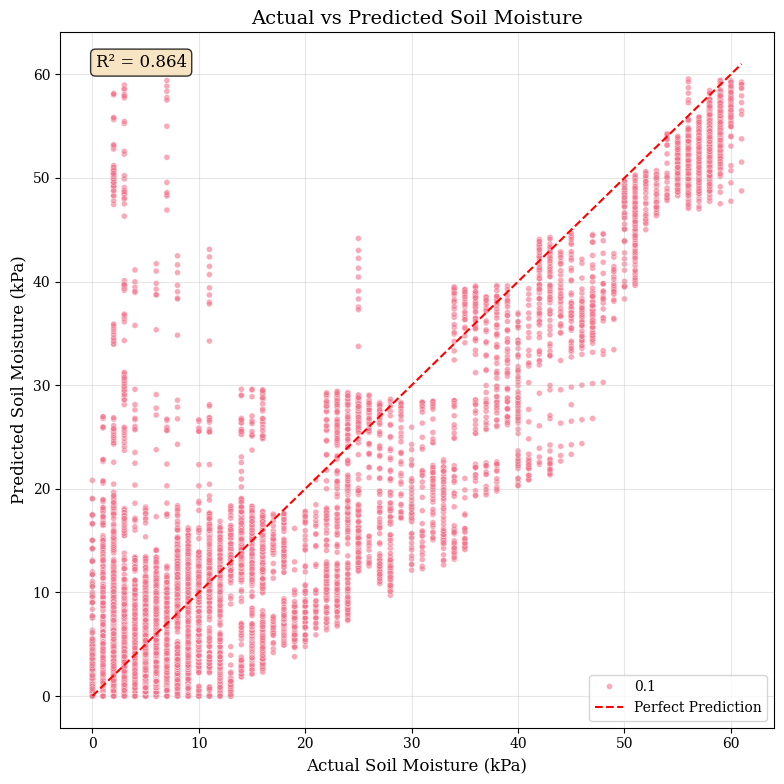

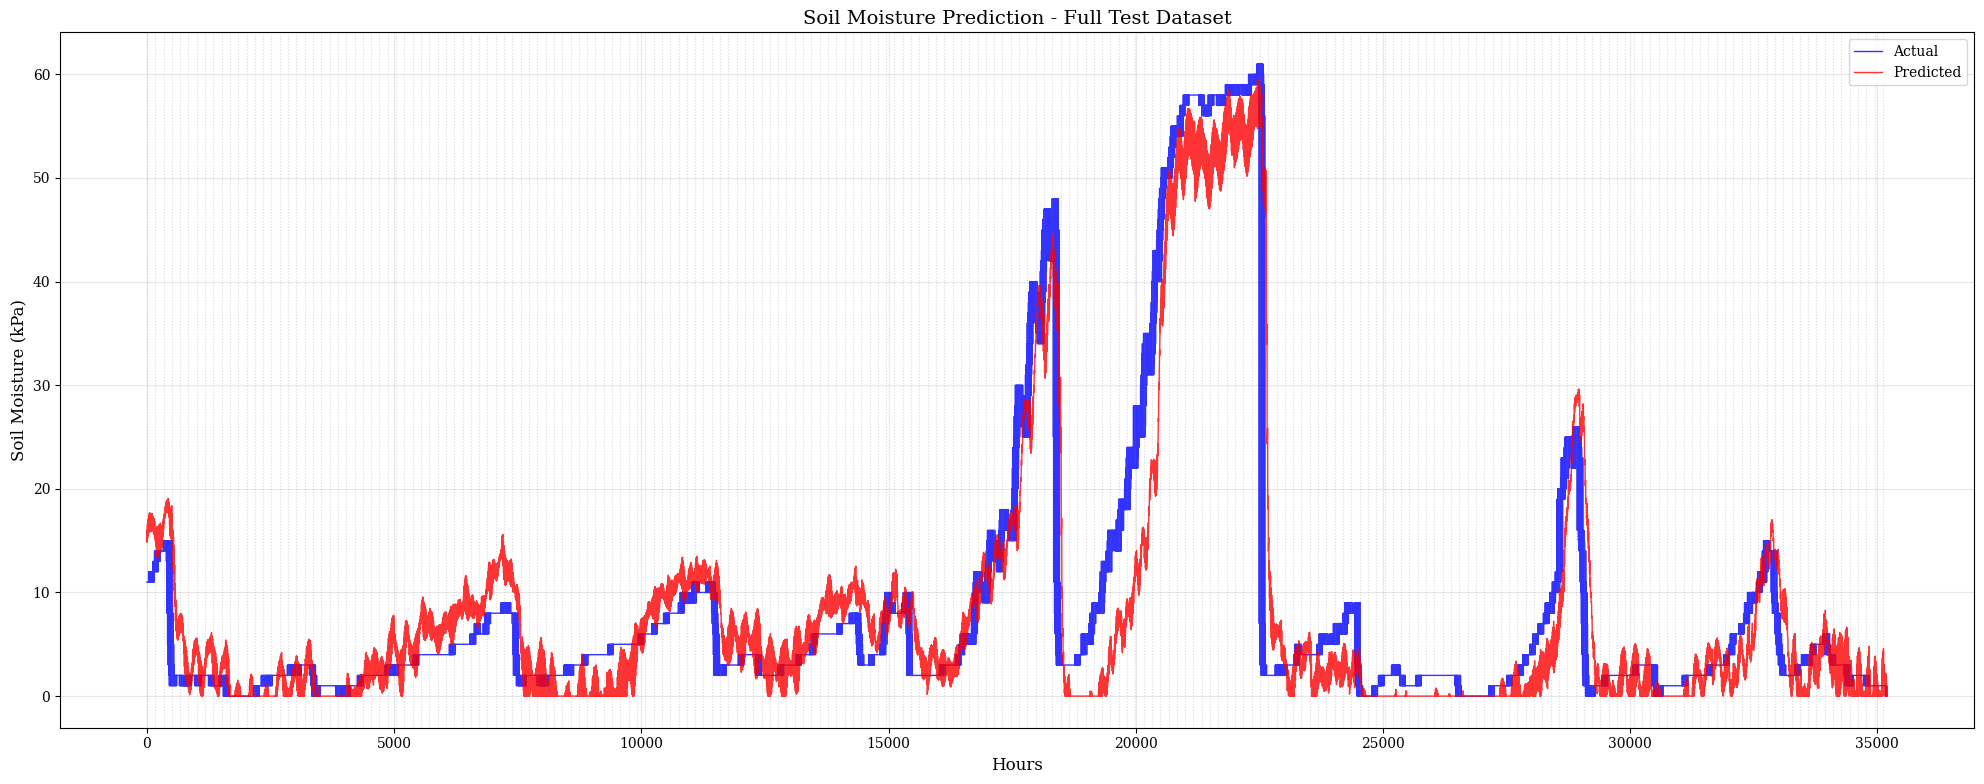

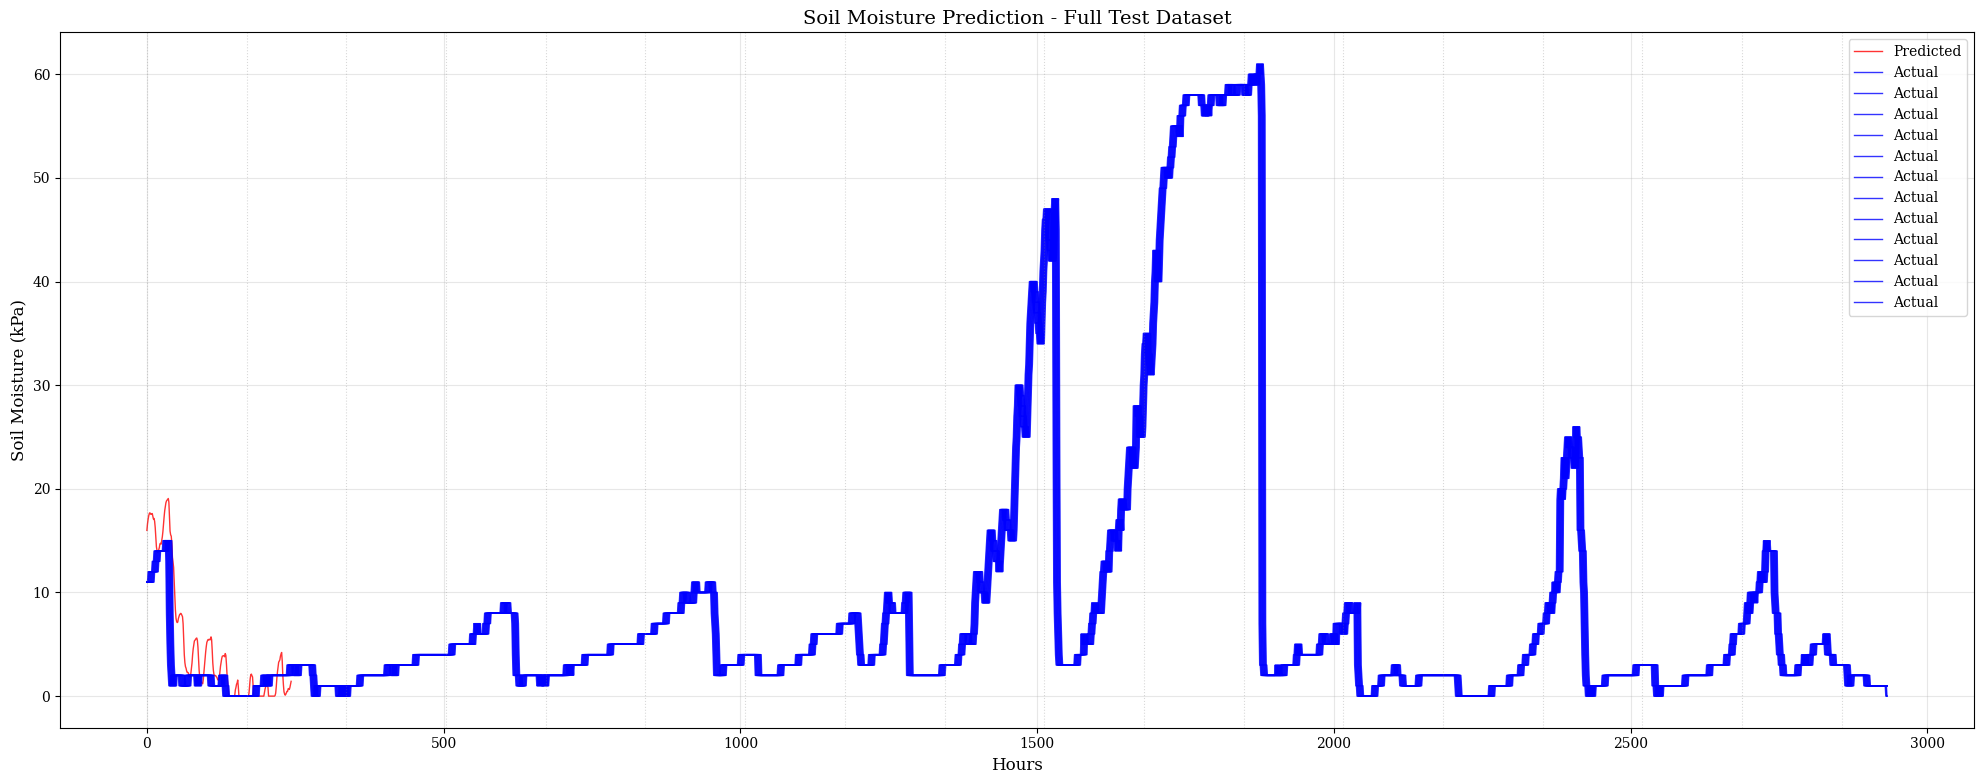

✅ Finished lstm_in168_out12_units64_20250616_013942


In [ ]:
# Call before each experiment
set_seeds(42)  # or different seeds for each run eg, 42, 123, 456

result = run_lstm_experiment(
    config=best_config,
    scaled_train=scaled_train,
    scaled_test=scaled_test,
    num_features=len(feature_cols),
    df_v2=df_v2,
    target_col=target,
    scaler=scaler,
    feature_cols=feature_cols
)

# Multiple experiments

In [ ]:
def run_multiple_experiments(n_runs, config, scaled_train, scaled_test, num_features, base_dir="results"):
    all_results = []

    for run in range(n_runs):
        # Call before each experiment
        set_seeds(42)  # or different seeds for each run


        print(f"\n Running Experiment {run + 1}/{n_runs}")
        run_id = f"run{run+1}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

        # Add experiment ID to config
        config["experiment_id"] = run_id

        run_log_path = os.path.join(base_dir, f"master_results_{run_id}.csv")

        result, y_true, y_pred = run_lstm_experiment(
            config=config,
            scaled_train=scaled_train,
            scaled_test=scaled_test,
            num_features=num_features,
            master_log_path=run_log_path
        )

        all_results.append(result)

    return pd.DataFrame(all_results)

In [ ]:
df_runs = run_multiple_experiments(
    n_runs=10,
    config=best_config,  # From Optuna or manual
    scaled_train=scaled_train,
    scaled_test=scaled_test,
    num_features=len(feature_cols)
)



 Running Experiment 1/10
Epoch 1/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 32s 38ms/step - loss: 0.0216
Epoch 2/50
  3/767 ━━━━━━━━━━━━━━━━━━━━ 28s 38ms/step - loss: 0.0035

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning:

Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss



767/767 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - loss: 0.0058
Epoch 3/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - loss: 0.0042
Epoch 4/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - loss: 0.0032
Epoch 5/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - loss: 0.0028
Epoch 6/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - loss: 0.0024
Epoch 7/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - loss: 0.0025
Epoch 8/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - loss: 0.0035
Epoch 9/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - loss: 0.0022
Epoch 10/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - loss: 0.0023
Epoch 11/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - loss: 0.0025
Epoch 12/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - loss: 0.0022
Epoch 13/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - loss: 0.0019
Epoch 14/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - loss: 0.0020
Epoch 15/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - loss: 0.0020
Epoch 16/50
767/767 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning:

Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss



767/767 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - loss: 0.1591
Epoch 3/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - loss: 0.1531
Epoch 4/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - loss: 0.1556
Epoch 5/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - loss: 0.1564
Epoch 6/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - loss: 0.1537
Epoch 7/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step - loss: 0.1574
Epoch 8/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - loss: 0.1569
Epoch 9/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - loss: 0.1530
Epoch 10/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - loss: 0.1579
Epoch 11/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - loss: 0.1553
Epoch 12/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step - loss: 0.1536
Epoch 13/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - loss: 0.1566
Epoch 14/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - loss: 0.1580
Epoch 15/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - loss: 0.1533
Epoch 16/50
767/767 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning:

Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss



767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - loss: 0.0060
Epoch 3/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - loss: 0.0035
Epoch 4/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step - loss: 0.0030
Epoch 5/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - loss: 0.0027
Epoch 6/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step - loss: 0.0026
Epoch 7/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - loss: 0.0024
Epoch 8/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step - loss: 0.0026
Epoch 9/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - loss: 0.0024
Epoch 10/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step - loss: 0.0022
Epoch 11/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step - loss: 0.0023
Epoch 12/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - loss: 0.0021
Epoch 13/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step - loss: 0.0020
Epoch 14/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - loss: 0.0018
Epoch 15/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - loss: 0.0018
Epoch 16/50
767/767 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning:

Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss



767/767 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - loss: 0.1585
Epoch 3/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 30s 40ms/step - loss: 0.1530
Epoch 4/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - loss: 0.1521
Epoch 5/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - loss: 0.1565
Epoch 6/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - loss: 0.1568
Epoch 7/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - loss: 0.1565
Epoch 8/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 30s 40ms/step - loss: 0.1560
Epoch 9/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - loss: 0.1557
Epoch 10/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - loss: 0.1572
Epoch 11/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - loss: 0.1510
Epoch 12/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - loss: 0.1588
Epoch 13/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - loss: 0.1523
Epoch 14/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - loss: 0.1532
Epoch 15/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - loss: 0.1527
Epoch 16/50
767/767 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning:

Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss



767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - loss: 0.0063
Epoch 3/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 30s 40ms/step - loss: 0.0038
Epoch 4/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - loss: 0.0028
Epoch 5/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 30s 40ms/step - loss: 0.0028
Epoch 6/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - loss: 0.0023
Epoch 7/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - loss: 0.0024
Epoch 8/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - loss: 0.0025
Epoch 9/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step - loss: 0.0021
Epoch 10/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - loss: 0.0020
Epoch 11/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - loss: 0.0020
Epoch 12/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - loss: 0.0019
Epoch 13/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step - loss: 0.0022
Epoch 14/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - loss: 0.0022
Epoch 15/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - loss: 0.0019
Epoch 16/50
767/767 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning:

Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss



767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - loss: 0.0059
Epoch 3/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - loss: 0.0037
Epoch 4/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - loss: 0.0029
Epoch 5/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - loss: 0.0026
Epoch 6/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step - loss: 0.0026
Epoch 7/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - loss: 0.0023
Epoch 8/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - loss: 0.0024
Epoch 9/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - loss: 0.0023
Epoch 10/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - loss: 0.0020
Epoch 11/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - loss: 0.0028
Epoch 12/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step - loss: 0.0019
Epoch 13/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - loss: 0.0020
Epoch 14/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - loss: 0.0019
Epoch 15/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - loss: 0.0017
Epoch 16/50
767/767 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning:

Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss



767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - loss: 0.0066
Epoch 3/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - loss: 0.0034
Epoch 4/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - loss: 0.0032
Epoch 5/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - loss: 0.0027
Epoch 6/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step - loss: 0.0024
Epoch 7/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - loss: 0.0024
Epoch 8/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - loss: 0.0023
Epoch 9/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step - loss: 0.0021
Epoch 10/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - loss: 0.0022
Epoch 11/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step - loss: 0.0022
Epoch 12/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step - loss: 0.0019
Epoch 13/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - loss: 0.0019
Epoch 14/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - loss: 0.0019
Epoch 15/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - loss: 0.0017
Epoch 16/50
767/767 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning:

Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss



767/767 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - loss: 0.1542
Epoch 3/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - loss: 0.1573
Epoch 4/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - loss: 0.1560
Epoch 5/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - loss: 0.1542
Epoch 6/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - loss: 0.1548
Epoch 7/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - loss: 0.1574
Epoch 8/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - loss: 0.1542
Epoch 9/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - loss: 0.1560
Epoch 10/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - loss: 0.1565
Epoch 11/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 30s 40ms/step - loss: 0.1503
Epoch 12/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - loss: 0.1539
Epoch 13/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - loss: 0.1518
Epoch 14/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - loss: 0.1507
Epoch 15/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - loss: 0.1556
Epoch 16/50
767/767 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning:

Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss



767/767 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step - loss: 0.1566
Epoch 3/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 30s 40ms/step - loss: 0.1574
Epoch 4/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - loss: 0.1591
Epoch 5/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - loss: 0.1570
Epoch 6/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step - loss: 0.1560
Epoch 7/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 30s 40ms/step - loss: 0.1546
Epoch 8/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - loss: 0.1487
Epoch 9/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step - loss: 0.1523
Epoch 10/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - loss: 0.1570
Epoch 11/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - loss: 0.1564
Epoch 12/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - loss: 0.1592
Epoch 13/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step - loss: 0.1578
Epoch 14/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - loss: 0.1552
Epoch 15/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step - loss: 0.1547
Epoch 16/50
767/767 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning:

Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss



767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - loss: 0.0060
Epoch 3/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - loss: 0.0034
Epoch 4/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - loss: 0.0031
Epoch 5/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - loss: 0.0027
Epoch 6/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 30s 40ms/step - loss: 0.0024
Epoch 7/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 30s 40ms/step - loss: 0.0026
Epoch 8/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - loss: 0.0022
Epoch 9/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - loss: 0.0023
Epoch 10/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - loss: 0.0019
Epoch 11/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - loss: 0.0019
Epoch 12/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 30s 40ms/step - loss: 0.0023
Epoch 13/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - loss: 0.0021
Epoch 14/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 30s 40ms/step - loss: 0.0019
Epoch 15/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - loss: 0.0018
Epoch 16/50
767/767 ━━━━━━━━━━━━━━━━━━━

In [ ]:
summary = df_runs[["R2", "RMSE", "NRMSE"]].agg(['mean', 'std'])
print(summary)

# Optional: Save this summary
summary.to_csv("results/lstm_run_summary.csv")

            R2      RMSE     NRMSE
mean  0.347091  0.048999  0.160652
std   0.641572  0.029974  0.098276


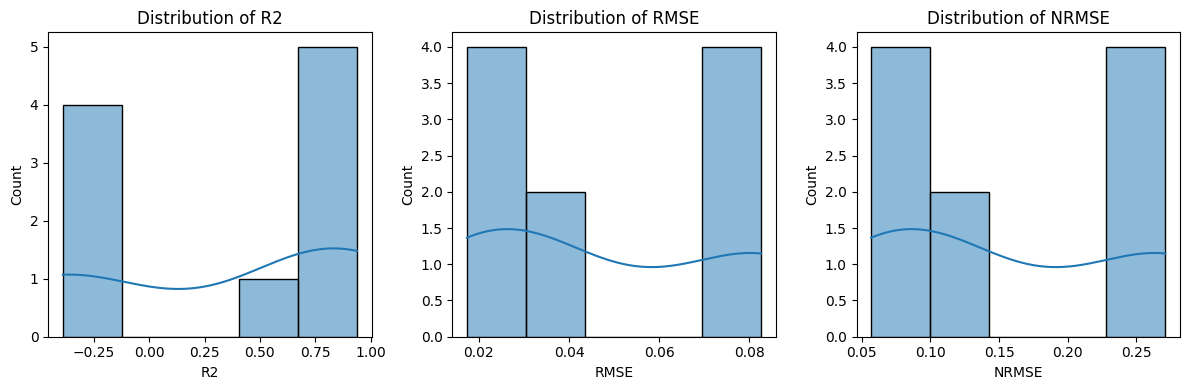

In [ ]:
plt.figure(figsize=(12, 4))
for metric in ["R2", "RMSE", "NRMSE"]:
    plt.subplot(1, 3, ["R2", "RMSE", "NRMSE"].index(metric) + 1)
    sns.histplot(df_runs[metric], kde=True)
    plt.title(f"Distribution of {metric}")
plt.tight_layout()
plt.savefig("results/lstm_run_distributions.png")
plt.show()

In [ ]:
def bootstrap_ci(data, n_bootstrap=1000, ci=95):
    means = [np.mean(np.random.choice(data, size=len(data), replace=True)) for _ in range(n_bootstrap)]
    lower = np.percentile(means, (100 - ci) / 2)
    upper = np.percentile(means, 100 - (100 - ci) / 2)
    return lower, upper

r2_ci = bootstrap_ci(df_runs["R2"])
print(f"R² 95% CI: {r2_ci}")

R² 95% CI: (np.float64(-0.025695780942623002), np.float64(0.7116678401869273))


In [ ]:
# prompt: download multiple files generated by scripts in colab

import zipfile
from google.colab import files
from datetime import datetime
# Correctly import the 'files' object from the google.colab module


def zip_results_directory(zip_filename="results.zip"):
  """Zips the 'results' directory for download."""
  with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files_list in os.walk("results"): # Renamed 'files' to 'files_list' to avoid conflict
      for file in files_list:
        zipf.write(os.path.join(root, file),
                   os.path.relpath(os.path.join(root, file), "results"))

  # Use the imported 'files' object for download
  files.download(zip_filename)

# Example usage after your script has run
zip_results_directory('results.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Appendix

In [ ]:
df = pd.read_csv("results/master_results.csv")
df.head()
df_no_residuals = df.drop(columns=["Residuals"])
df_no_residuals.to_csv("results/master_results.csv", index=False)

In [ ]:
!rm -rf results

In [ ]:
    from google.colab import files
    uploaded = files.upload()

In [ ]:
import optuna

study = optuna.load_study(
    study_name="lstm_study",
    storage="sqlite:///lstm_optuna.db"
)


In [ ]:
def forecast_examples(y_test_original, y_pred_original, save_path, output_seq=48):
    """Figure 4: Best Forecast Examples - Selected by R² score"""

    # Reshape to sequences
    n_sequences = len(y_test_original) // output_seq
    y_test_seq = y_test_original[:n_sequences*output_seq].reshape(n_sequences, output_seq)
    y_pred_seq = y_pred_original[:n_sequences*output_seq].reshape(n_sequences, output_seq)

    # Calculate R² for each sequence
    r2_scores = []
    for i in range(n_sequences):
        r2 = r2_score(y_test_seq[i], y_pred_seq[i])
        r2_scores.append((r2, i))

    # Sort by R² and select top examples
    r2_scores.sort(reverse=True)  # Best fits first

    # Take top 3-5 examples
    best_indices = [idx for _, idx in r2_scores[:3]]

    # Create the plot
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))
    colors = ['#2E86AB', '#F18F01', '#A23B72']

    for i, idx in enumerate(best_indices):
        ax = axes[i]
        hours = np.arange(1, output_seq + 1)
        actual = y_test_seq[idx]
        predicted = y_pred_seq[idx]

        ax.plot(hours, actual, 'o-', color=colors[i], linewidth=3, markersize=8,
                label='Actual', alpha=0.9)
        ax.plot(hours, predicted, 's--', color='red', linewidth=2.5, markersize=7,
                label='Predicted', alpha=0.9)

        # Calculate metrics
        r2_example = r2_score(actual, predicted)
        mae_example = np.mean(np.abs(actual - predicted))

        ax.set_xlabel('Forecast Horizon (hours)')
        ax.set_ylabel('Soil Moisture (kPa)')
        ax.set_title(f'({chr(65+i)}) Example {i+1} - R² = {r2_example:.3f}, MAE = {mae_example:.1f} kPa',
                    fontweight='bold', fontsize=14)
        ax.legend(fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.set_xticks(hours)

        # Add subtle error bars
        for j, (h, a, p) in enumerate(zip(hours, actual, predicted)):
            ax.plot([h, h], [a, p], 'gray', alpha=0.4, linewidth=1)

    plt.suptitle('Representative High-Performance Forecast Examples', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f"{save_path}/Figure4_Best_Forecast_Examples.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Report what percentile these represent
    all_r2 = [r2 for r2, _ in r2_scores]
    for i, (r2, _) in enumerate(r2_scores[:3]):
        percentile = (1 - i/len(r2_scores)) * 100
        print(f"Example {i+1}: R² = {r2:.3f} (top {percentile:.1f}% of predictions)")

def challenging_examples(y_test_kPa, y_pred_kPa, save_path, output_seq=48):
    """Figure 5: Challenging Forecast Examples - Selected by poorest performance"""

    # Reshape to sequences
    n_sequences = len(y_test_kPa) // output_seq
    y_test_seq = y_test_kPa[:n_sequences*output_seq].reshape(n_sequences, output_seq)
    y_pred_seq = y_pred_kPa[:n_sequences*output_seq].reshape(n_sequences, output_seq)

    # Calculate performance metrics for each sequence
    performance_scores = []
    for i in range(n_sequences):
        r2 = r2_score(y_test_seq[i], y_pred_seq[i])
        mae = np.mean(np.abs(y_test_seq[i] - y_pred_seq[i]))
        rmse = np.sqrt(np.mean((y_test_seq[i] - y_pred_seq[i])**2))

        # Use combined score (lower is worse)
        combined_score = r2 - (mae / 10)  # Weight R² more heavily
        performance_scores.append((combined_score, r2, mae, rmse, i))

    # Sort by performance (worst first)
    performance_scores.sort(key=lambda x: x[0])

    # Select worst examples, but filter out completely unrealistic ones
    challenging_examples = []
    for score, r2, mae, rmse, idx in performance_scores:
        # Filter criteria: challenging but not completely broken
        if r2 > -0.5 and mae < 20:  # Adjust thresholds as needed
            challenging_examples.append((score, r2, mae, rmse, idx))
        if len(challenging_examples) >= 4:  # Get top 4 challenging cases
            break

    # Create the plot
    fig, axes = plt.subplots(len(challenging_examples), 1, figsize=(12, 3.5*len(challenging_examples)))
    if len(challenging_examples) == 1:
        axes = [axes]

    colors = ['#E63946', '#F77F00', '#FCBF49', '#277DA1']  # Red to orange palette

    for i, (score, r2, mae, rmse, idx) in enumerate(challenging_examples):
        ax = axes[i]
        hours = np.arange(1, output_seq + 1)
        actual = y_test_seq[idx]
        predicted = y_pred_seq[idx]

        # Plot with different style to emphasize challenges
        ax.plot(hours, actual, 'o-', color=colors[i], linewidth=3, markersize=8,
                label='Actual', alpha=0.9)
        ax.plot(hours, predicted, 's--', color='darkred', linewidth=2.5, markersize=7,
                label='Predicted', alpha=0.9)

        # Add prediction intervals/uncertainty
        errors = np.abs(actual - predicted)
        ax.fill_between(hours, predicted - errors, predicted + errors,
                        alpha=0.2, color='red', label='Error magnitude')

        ax.set_xlabel('Forecast Horizon (hours)')
        ax.set_ylabel('Soil Moisture (kPa)')
        ax.set_title(f'({chr(65+i)}) Challenging Case {i+1} - R² = {r2:.3f}, MAE = {mae:.1f} kPa, RMSE = {rmse:.1f} kPa',
                    fontweight='bold', fontsize=12)
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.set_xticks(hours)

        # Highlight error bars more prominently
        for j, (h, a, p) in enumerate(zip(hours, actual, predicted)):
            ax.plot([h, h], [a, p], 'darkred', alpha=0.6, linewidth=2)

        # Add annotation about the challenge
        if mae > 5:
            ax.annotate('High prediction error', xy=(output_seq*0.7, max(actual.max(), predicted.max())*0.9),
                       fontsize=10, color='red', style='italic')

    plt.suptitle('Challenging Forecast Examples: Model Limitations', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f"{save_path}/Figure5_Challenging_Examples.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Report what percentile these represent
    all_scores = [score for score, _, _, _, _ in performance_scores]
    print("🚨 CHALLENGING EXAMPLES ANALYSIS:")
    for i, (score, r2, mae, rmse, _) in enumerate(challenging_examples):
        percentile = (i / len(performance_scores)) * 100
        print(f"  Example {i+1}: R² = {r2:.3f}, MAE = {mae:.1f} kPa (bottom {percentile:.1f}% of predictions)")

    return challenging_examples

def plot_forecast_examples(y_test_original, y_pred_original, save_path, num_examples=5):
    random.seed(42)
    indices = random.sample(range(len(y_test_original)), num_examples)
    out_len = y_test_original.shape[1]

    plt.figure(figsize=(15, num_examples * 3))
    for i, idx in enumerate(indices):
        plt.subplot(num_examples, 1, i + 1)
        plt.plot(range(out_len), y_test_original[idx], label='Actual', marker='o')
        plt.plot(range(out_len), y_pred_original[idx], label='Predicted', marker='x')
        plt.title(f"Forecast Example {i+1}")
        plt.xlabel("Forecast Horizon (hours)")
        plt.ylabel("Soil Moisture (kPa)")
        #plt.yticks(0, 0.03)
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, 'forecast_examples.png'))
    plt.close()

# Scatter Plot
def plot_scatter(y_test_flat, y_pred_flat, save_path):
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_test_flat, y=y_pred_flat, alpha=0.5)
    plt.plot([y_test_flat.min(), y_test_flat.max()], [y_test_flat.min(), y_test_flat.max()], 'r--')
    plt.xlabel("Actual Soil Moisture (scaled)")
    plt.ylabel("Predicted Soil Moisture (scaled)")
    plt.title("Actual vs Predicted Scatter")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, 'scatter_plot.png'))
    plt.close()

def plot_time_series_sample(y_test_original, y_pred_original, save_path, sample_length=168):
    """Plot a week-long sample to see patterns"""

    plt.figure(figsize=(15, 6))

    # Take first week of predictions
    end_idx = min(sample_length, len(y_test_original))
    time_hours = np.arange(end_idx)

    plt.plot(time_hours, y_test_original[:end_idx], 'b-', label='Actual', linewidth=2)
    plt.plot(time_hours, y_pred_original[:end_idx], 'r--', label='Predicted', linewidth=2)

    plt.xlabel("Hours")
    plt.ylabel("Soil Moisture (kPa)")
    plt.ylim(0, None)
    plt.title("Soil Moisture Prediction - Sample Week")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Add day markers
    for day in range(0, end_idx, 24):
        plt.axvline(x=day, color='gray', alpha=0.5, linestyle=':')

    plt.tight_layout()
    plt.savefig(os.path.join(save_path, 'time_series_sample_kPa.png'), dpi=300)
    plt.show()

def relative_error(y_test_original, y_pred_original, save_path):

    # Relative Error vs Time (with moving average)

    # Calculate relative error (percentage)
    relative_error = ((y_pred_original - y_test_original) / y_test_original) * 100
    time_hours = np.arange(len(relative_error))

    # Plot raw relative error (lighter)
    plt.plot(time_hours, relative_error, color='#2E86AB', alpha=0.3, linewidth=0.5, label='Raw error')

    # Add moving average for trend
    window_size = 24  # 24-hour moving average
    if len(relative_error) > window_size:
        moving_avg = pd.Series(relative_error).rolling(window=window_size, center=True).mean()
        plt.plot(time_hours, moving_avg, color='#2E86AB', linewidth=2, label=f'{window_size}h moving avg')

    # Add zero line and error bands
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.8, linewidth=1)
    plt.axhline(y=20, color='orange', linestyle=':', alpha=0.6, linewidth=1, label='±20% error')
    plt.axhline(y=-20, color='orange', linestyle=':', alpha=0.6, linewidth=1)

    plt.xlabel('Time (hours)')
    plt.ylabel('Relative Error (%)')
    plt.title('(D) Relative Error vs Time', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(-200, 200)

    plt.tight_layout()
    plt.savefig(f"{save_path}/Figure3_Performance_Analysis.png", dpi=300, bbox_inches='tight')
    plt.show()

def perf_moisture_condition(y_test_original, y_pred_original, save_path):
    # Subplot C: Performance by moisture conditions

    conditions = ['Saturated\n(0-10)', 'Moderate\n(11-50)', 'Dry\n(51-100)', 'Very Dry\n(>100)']

    # Calculate R² for each condition
    masks = [
        y_test_original <= 10,
        (y_test_original > 10) & (y_test_original <= 50),
        (y_test_original > 50) & (y_test_original <= 100),
        y_test_original > 100
    ]

    r2_values = []
    mae_values = []
    sample_counts = []

    for mask in masks:
        if mask.sum() > 0:
            r2_cond = r2_score(y_test_original[mask], y_pred_original[mask])
            mae_cond = np.mean(np.abs(y_test_original[mask] - y_pred_original[mask]))
            r2_values.append(r2_cond)
            mae_values.append(mae_cond)
            sample_counts.append(mask.sum())
        else:
            r2_values.append(0)
            mae_values.append(0)
            sample_counts.append(0)

    x_pos = np.arange(len(conditions))
    bars = plt.bar(x_pos, r2_values, color=['#F18F01', '#C73E1D', '#2E86AB', '#A23B72'], alpha=0.8)

    # Add sample count labels
    for i, (bar, count) in enumerate(zip(bars, sample_counts)):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'n={count}', ha='center', va='bottom', fontsize=9)

    plt.ylabel('R² Score')
    plt.title('(C) Performance by Moisture Condition', fontweight='bold')
    plt.xticks(x_pos)
    plt.xticks([0, 1, 2, 3], conditions)
    plt.grid(True, alpha=0.3, axis='y')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)


## Diagnostics for stepwise result

In [ ]:
print("Original shapes:")
print(f"y_test_flat shape: {y_test_flat.shape}")
print(f"y_pred_flat shape: {y_pred_flat.shape}")
print(f"df_v2 shape: {df_v2.shape}")
print(f"Target column shape: {df_v2[target].shape}")

Original shapes:
y_test_flat shape: (3112,)
y_pred_flat shape: (17634,)
df_v2 shape: (15557, 28)
Target column shape: (15557,)


In [ ]:
print("Checking sequence configuration:")
print(f"Input sequence length: {best_config['input_seq']}")
print(f"Output sequence length: {best_config['output_seq']}")

# Calculate expected shapes
input_seq = best_config['input_seq']
output_seq = best_config['output_seq']
test_data_length = len(scaled_test)

expected_sequences = test_data_length - input_seq - output_seq + 1
expected_total_predictions = expected_sequences * output_seq

print(f"Expected number of sequences: {expected_sequences}")
print(f"Expected total predictions: {expected_total_predictions}")
print(f"Actual y_pred_flat length: {y_pred_flat.shape[0]}")
print(f"Actual y_test_flat length: {y_test_flat.shape[0]}")

Checking sequence configuration:
Input sequence length: 168
Output sequence length: 6
Expected number of sequences: 2939
Expected total predictions: 17634
Actual y_pred_flat length: 17634
Actual y_test_flat length: 3112


In [ ]:
# Let's check what's happening in your data creation
input_seq = 168
output_seq = 6

# Recreate the test data to see shapes
X_test, y_test = create_seq2seq_data(scaled_test, input_seq, output_seq)

print("Debug shapes:")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"y_test flattened should be: {y_test.flatten().shape}")

# Check if your y_test is being created correctly
expected_y_test_flat_length = y_test.shape[0] * y_test.shape[1]
print(f"Expected y_test_flat length: {expected_y_test_flat_length}")

Debug shapes:
X_test shape: (2939, 168, 17)
y_test shape: (2939, 6)
y_test flattened should be: (17634,)
Expected y_test_flat length: 17634


In [ ]:
# Check if predictions are actually discrete
print("Unique predicted values (first 50):")
print(sorted(np.unique(y_pred_kPa))[:50])

print("\nUnique actual values (first 50):")
print(sorted(np.unique(y_test_kPa))[:50])

# Check the range and distribution
print(f"\nPredicted range: {y_pred_kPa.min():.3f} to {y_pred_kPa.max():.3f}")
print(f"Actual range: {y_test_kPa.min():.3f} to {y_test_kPa.max():.3f}")

# Look at raw model outputs before unscaling
print(f"\nRaw prediction range (scaled): {y_pred_flat.min():.6f} to {y_pred_flat.max():.6f}")

Unique predicted values (first 50):
[np.float64(0.0), np.float64(0.0004902482032775879), np.float64(0.000546872615814209), np.float64(0.0016450881958007812), np.float64(0.002376735210418701), np.float64(0.0023871660232543945), np.float64(0.003165006637573242), np.float64(0.0034064054489135742), np.float64(0.003649294376373291), np.float64(0.004926323890686035), np.float64(0.005207955837249756), np.float64(0.005526840686798096), np.float64(0.00798255205154419), np.float64(0.009594857692718506), np.float64(0.013056397438049316), np.float64(0.013089179992675781), np.float64(0.013968348503112793), np.float64(0.014711916446685791), np.float64(0.014820694923400879), np.float64(0.016735494136810303), np.float64(0.017780065536499023), np.float64(0.021004676818847656), np.float64(0.022117793560028076), np.float64(0.024364888668060303), np.float64(0.025224685668945312), np.float64(0.026465952396392822), np.float64(0.029174983501434326), np.float64(0.029633939266204834), np.float64(0.029875338077

In [ ]:
# Check what's happening during unscaling
print("Debug unscaling process:")
print(f"Original data range: {df_v2[target].min():.3f} to {df_v2[target].max():.3f}")

# Check a sample of original continuous values
print(f"Sample original values: {df_v2[target].head(20).values}")

# Check the scaling parameters
original_target = df_v2[target].values
target_min, target_max = original_target.min(), original_target.max()
print(f"Scaling range: {target_min} to {target_max}")

# Check raw scaled values before unscaling
print(f"Sample scaled test values: {y_test_flat[:10]}")

# Manual unscaling step-by-step
manual_unscaled = y_test_flat[:10] * (target_max - target_min) + target_min
print(f"Manual unscaled: {manual_unscaled}")

Debug unscaling process:
Original data range: 0.000 to 200.000
Sample original values: [4 4 3 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5]
Scaling range: 0 to 200
Sample scaled test values: [[0.055 0.055 0.055 0.055 0.055 0.055]
 [0.055 0.055 0.055 0.055 0.055 0.055]
 [0.055 0.055 0.055 0.055 0.055 0.055]
 [0.055 0.055 0.055 0.055 0.055 0.055]
 [0.055 0.055 0.055 0.055 0.055 0.055]
 [0.055 0.055 0.055 0.055 0.055 0.055]
 [0.055 0.055 0.055 0.055 0.055 0.055]
 [0.055 0.055 0.055 0.055 0.055 0.055]
 [0.055 0.055 0.055 0.055 0.055 0.06 ]
 [0.055 0.055 0.055 0.055 0.06  0.06 ]]
Manual unscaled: [[11. 11. 11. 11. 11. 11.]
 [11. 11. 11. 11. 11. 11.]
 [11. 11. 11. 11. 11. 11.]
 [11. 11. 11. 11. 11. 11.]
 [11. 11. 11. 11. 11. 11.]
 [11. 11. 11. 11. 11. 11.]
 [11. 11. 11. 11. 11. 11.]
 [11. 11. 11. 11. 11. 11.]
 [11. 11. 11. 11. 11. 12.]
 [11. 11. 11. 11. 12. 12.]]


In [ ]:
# Check where discretization occurs
print("=== Debugging Discretization ===")

# 1. Check original data precision
print("Original data sample (should be continuous):")
print(df_v2[target].head(20).values)
print(f"Original unique values count: {len(df_v2[target].unique())}")

# 2. Check feature engineering
print("\nAfter feature engineering:")
print(f"df_v2[target] dtype: {df_v2[target].dtype}")
print(f"Sample values: {df_v2[target][1000:1020].values}")

# 3. Check scaling process
scaler_debug = MinMaxScaler()
target_scaled_debug = scaler_debug.fit_transform(df_v2[[target]])
print(f"\nAfter scaling:")
print(f"Scaled dtype: {target_scaled_debug.dtype}")
print(f"Unique scaled values count: {len(np.unique(target_scaled_debug))}")
print(f"Sample scaled: {target_scaled_debug[1000:1020, 0]}")

# 4. Check the combined scaling
print(f"\nCombined scaled_all:")
print(f"scaled_all dtype: {scaled_all.dtype}")
print(f"Target column unique count: {len(np.unique(scaled_all[:, -1]))}")

=== Debugging Discretization ===
Original data sample (should be continuous):
[4 4 3 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5]
Original unique values count: 201

After feature engineering:
df_v2[target] dtype: int64
Sample values: [200 200 200 200 200 200 200 200 200 200 200 200 200 200 200 200 200 200
 200 200]

After scaling:
Scaled dtype: float64
Unique scaled values count: 201
Sample scaled: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Combined scaled_all:
scaled_all dtype: float64
Target column unique count: 201


In [ ]:
def debug_feature_engineering_pipeline(df, target_col='SH1_SoilMoisture_4in_kPa'):
    """
    Debug the feature engineering pipeline to find where discretization occurs
    """
    print("=== DEBUGGING FEATURE ENGINEERING PIPELINE ===\n")

    # Step 0: Check original data
    print("STEP 0: Original DataFrame")
    print(f"Shape: {df.shape}")
    print(f"Target dtype: {df[target_col].dtype}")
    print(f"Target unique values count: {len(df[target_col].unique())}")
    print(f"Target sample values: {df[target_col].head(20).values}")
    print(f"Target mean: {df[target_col].mean():.6f}")
    print(f"Target std: {df[target_col].std():.6f}")
    print(f"Target min/max: {df[target_col].min():.3f} / {df[target_col].max():.3f}")
    print("-" * 60)

    # Step 1: Copy and basic operations
    df_debug = df.copy()
    df_debug['DateTime'] = pd.to_datetime(df_debug['DateTime'])
    df_debug = df_debug.sort_values('DateTime').reset_index(drop=True)

    print("STEP 1: After copy, datetime parsing, and sorting")
    print(f"Target dtype: {df_debug[target_col].dtype}")
    print(f"Target unique values count: {len(df_debug[target_col].unique())}")
    print(f"Target sample values: {df_debug[target_col].head(20).values}")
    print(f"Target mean: {df_debug[target_col].mean():.6f}")
    print("-" * 60)

    # Step 2: Time-based encodings
    df_debug['hour'] = df_debug['DateTime'].dt.hour
    df_debug['day_of_year'] = df_debug['DateTime'].dt.dayofyear
    df_debug['sin_hour'] = np.sin(2 * np.pi * df_debug['hour'] / 24)
    df_debug['cos_hour'] = np.cos(2 * np.pi * df_debug['hour'] / 24)
    df_debug['sin_doy'] = np.sin(2 * np.pi * df_debug['day_of_year'] / 365)
    df_debug['cos_doy'] = np.cos(2 * np.pi * df_debug['day_of_year'] / 365)

    print("STEP 2: After time-based encodings")
    print(f"Target dtype: {df_debug[target_col].dtype}")
    print(f"Target unique values count: {len(df_debug[target_col].unique())}")
    print(f"Target sample values: {df_debug[target_col].head(20).values}")
    print(f"Target mean: {df_debug[target_col].mean():.6f}")
    print("-" * 60)

    # Step 3: Rolling features (this is suspicious)
    print("STEP 3: Adding rolling features...")
    df_debug['Rain_7day_sum'] = df_debug['Rain_mm'].rolling(window=168).sum()
    print(f"After Rain_7day_sum - Target dtype: {df_debug[target_col].dtype}")
    print(f"Target unique count: {len(df_debug[target_col].unique())}")

    df_debug['Rain_7day_avg'] = df_debug['Rain_mm'].rolling(window=168).mean()
    print(f"After Rain_7day_avg - Target dtype: {df_debug[target_col].dtype}")
    print(f"Target unique count: {len(df_debug[target_col].unique())}")

    df_debug['ET_7day_sum'] = df_debug['ET_mm'].rolling(window=168).sum()
    print(f"After ET_7day_sum - Target dtype: {df_debug[target_col].dtype}")
    print(f"Target unique count: {len(df_debug[target_col].unique())}")

    df_debug['Temp_7day_avg'] = df_debug['Temp_C'].rolling(window=168).mean()
    print(f"After Temp_7day_avg - Target dtype: {df_debug[target_col].dtype}")
    print(f"Target unique count: {len(df_debug[target_col].unique())}")
    print("-" * 60)

    # Step 4: Environmental interactions
    print("STEP 4: Adding environmental interactions...")
    df_debug['Rain_ET_Balance_7day'] = df_debug['Rain_7day_sum'] - df_debug['ET_7day_sum']
    print(f"After Rain_ET_Balance - Target dtype: {df_debug[target_col].dtype}")
    print(f"Target unique count: {len(df_debug[target_col].unique())}")

    df_debug['Rain_Temp_ratio'] = df_debug['Rain_mm'] / df_debug['Temp_C'].replace(0, np.nan)
    print(f"After Rain_Temp_ratio - Target dtype: {df_debug[target_col].dtype}")
    print(f"Target unique count: {len(df_debug[target_col].unique())}")

    df_debug['ET_HI_Interaction'] = df_debug['ET_mm'] * df_debug['HeatIndex_C']
    print(f"After ET_HI_Interaction - Target dtype: {df_debug[target_col].dtype}")
    print(f"Target unique count: {len(df_debug[target_col].unique())}")
    print("-" * 60)

    # Step 5: Wet hours calculation
    print("STEP 5: Adding wet hours...")
    df_debug['Wet_hours_last_7d'] = df_debug['Rain_mm'].gt(0.1).rolling(window=168).sum()
    print(f"After Wet_hours - Target dtype: {df_debug[target_col].dtype}")
    print(f"Target unique count: {len(df_debug[target_col].unique())}")
    print("-" * 60)

    # Step 6: Lag features
    print("STEP 6: Adding lag features...")
    df_debug['SoilMoisture_t-1'] = df_debug[target_col].shift(1)
    print(f"After SoilMoisture lag - Target dtype: {df_debug[target_col].dtype}")
    print(f"Target unique count: {len(df_debug[target_col].unique())}")

    df_debug['Rain_t-1'] = df_debug['Rain_mm'].shift(1)
    print(f"After Rain lag - Target dtype: {df_debug[target_col].dtype}")
    print(f"Target unique count: {len(df_debug[target_col].unique())}")

    df_debug['ET_t-1'] = df_debug['ET_mm'].shift(1)
    print(f"After ET lag - Target dtype: {df_debug[target_col].dtype}")
    print(f"Target unique count: {len(df_debug[target_col].unique())}")
    print("-" * 60)

    # Step 7: dropna (MOST SUSPICIOUS!)
    print("STEP 7: Before dropna")
    print(f"Shape before dropna: {df_debug.shape}")
    print(f"Target dtype before dropna: {df_debug[target_col].dtype}")
    print(f"Target unique count before dropna: {len(df_debug[target_col].unique())}")
    print(f"Target sample before dropna: {df_debug[target_col].head(20).values}")

    df_debug.dropna(inplace=True)

    print("STEP 7: After dropna")
    print(f"Shape after dropna: {df_debug.shape}")
    print(f"Target dtype after dropna: {df_debug[target_col].dtype}")
    print(f"Target unique count after dropna: {len(df_debug[target_col].unique())}")
    print(f"Target sample after dropna: {df_debug[target_col].head(20).values}")
    print(f"Target mean after dropna: {df_debug[target_col].mean():.6f}")
    print("-" * 60)

    # Final check - examine all dtypes
    print("FINAL: All column dtypes")
    for col in df_debug.columns:
        print(f"{col}: {df_debug[col].dtype}")

    print(f"\nFINAL TARGET CHECK:")
    print(f"Target range: {df_debug[target_col].min():.3f} to {df_debug[target_col].max():.3f}")
    print(f"Is target integer? {df_debug[target_col].dtype == 'int64'}")
    print(f"Target precision test: {df_debug[target_col].iloc[1000:1010].values}")

    return df_debug

# Run the debug
df_debugged = debug_feature_engineering_pipeline(df, target)

=== DEBUGGING FEATURE ENGINEERING PIPELINE ===

STEP 0: Original DataFrame
Shape: (15724, 11)
Target dtype: int64
Target unique values count: 201
Target sample values: [1 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3]
Target mean: 40.699122
Target std: 57.012911
Target min/max: 0.000 / 200.000
------------------------------------------------------------
STEP 1: After copy, datetime parsing, and sorting
Target dtype: int64
Target unique values count: 201
Target sample values: [1 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3]
Target mean: 40.699122
------------------------------------------------------------
STEP 2: After time-based encodings
Target dtype: int64
Target unique values count: 201
Target sample values: [1 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3]
Target mean: 40.699122
------------------------------------------------------------
STEP 3: Adding rolling features...
After Rain_7day_sum - Target dtype: int64
Target unique count: 201
After Rain_7day_avg - Target dtype: int64
Target unique count: 20

In [ ]:
print("=== DEBUGGING CSV LOADING ===")

# Check the raw CSV data
print("1. Raw CSV file check:")
df_raw = pd.read_csv("/content/combined_hourly_data_cleaned.csv")
print(f"Raw target dtype: {df_raw['SH1_SoilMoisture_4in_kPa'].dtype}")
print(f"Raw target sample: {df_raw['SH1_SoilMoisture_4in_kPa'].head(20).values}")
print(f"Raw unique count: {len(df_raw['SH1_SoilMoisture_4in_kPa'].unique())}")

# Check the file contents directly
print("\n2. First few lines of CSV:")
with open("/content/combined_hourly_data_cleaned.csv", 'r') as f:
    for i, line in enumerate(f):
        print(f"Line {i}: {line.strip()}")
        if i >= 5:  # Show first 6 lines
            break

# Check specific soil moisture column
print(f"\n3. Soil moisture column values (first 20 rows):")
soil_values = df_raw['SH1_SoilMoisture_4in_kPa'].head(20)
for i, val in enumerate(soil_values):
    print(f"Row {i}: {val} (type: {type(val)})")

=== DEBUGGING CSV LOADING ===
1. Raw CSV file check:
Raw target dtype: int64
Raw target sample: [1 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3]
Raw unique count: 201

2. First few lines of CSV:
Line 0: DateTime,Temp_C,Hum_%,WindSpeed_kmph,HeatIndex_C,Rain_mm,RainRate_mmph,ET_mm,SH1_SoilMoisture_4in_kPa,SH1_SoilMoisture_20in_kPa,SH1_SoilMoisture_36in_kPa
Line 1: 04/02/2023 13:00,28,75,21,31,0,0,0.6,1,0,0
Line 2: 04/02/2023 14:00,26,81,21,29,0,0,0.4,2,0,0
Line 3: 04/02/2023 15:00,28,76,23,31,0,0,0.4,2,0,0
Line 4: 04/02/2023 16:00,27,79,21,29,0,0,0.2,2,0,0
Line 5: 04/02/2023 17:00,26,81,21,29,0,0,0.1,2,0,0

3. Soil moisture column values (first 20 rows):
Row 0: 1 (type: <class 'int'>)
Row 1: 2 (type: <class 'int'>)
Row 2: 2 (type: <class 'int'>)
Row 3: 2 (type: <class 'int'>)
Row 4: 2 (type: <class 'int'>)
Row 5: 2 (type: <class 'int'>)
Row 6: 2 (type: <class 'int'>)
Row 7: 2 (type: <class 'int'>)
Row 8: 2 (type: <class 'int'>)
Row 9: 2 (type: <class 'int'>)
Row 10: 3 (type: <class 'int'>)
Row 

In [ ]:
# Check if you're looking at different data
print("=== COMPARING DATAFRAMES ===")
print("Original df (from describe):")
print(f"df shape: {df.shape}")
print(f"df target dtype: {df[target].dtype}")
print(f"df target sample: {df[target].head(20).values}")
print(f"df target mean: {df[target].mean():.6f}")

print("\nRaw loaded df:")
df_raw = pd.read_csv("/content/combined_hourly_data_cleaned.csv")
print(f"df_raw shape: {df_raw.shape}")
print(f"df_raw target dtype: {df_raw[target].dtype}")
print(f"df_raw target sample: {df_raw[target].head(20).values}")
print(f"df_raw target mean: {df_raw[target].mean():.6f}")

print("\nAre they the same DataFrame?")
print(f"Same shape: {df.shape == df_raw.shape}")
print(f"Same values: {df[target].equals(df_raw[target])}")

=== COMPARING DATAFRAMES ===
Original df (from describe):
df shape: (15724, 11)
df target dtype: int64
df target sample: [1 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3]
df target mean: 40.699122

Raw loaded df:
df_raw shape: (15724, 11)
df_raw target dtype: int64
df_raw target sample: [1 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3]
df_raw target mean: 40.699122

Are they the same DataFrame?
Same shape: True
Same values: True


In [ ]:
# This SHOULD be impossible if data is truly integers
integer_array = np.array([1, 2, 2, 2, 3, 3, 3])  # Integer like your data
print(f"Integer array mean: {integer_array.mean()}")  # This will be something like 2.285714

# Your describe showed 40.699 - that means values much higher than 1,2,3
# Let's see what values would give that mean:
target_mean = 40.699
data_length = len(df)
required_sum = target_mean * data_length
print(f"To get mean {target_mean} with {data_length} values, sum must be: {required_sum}")
print(f"Actual sum of your data: {df[target].sum()}")

Integer array mean: 2.2857142857142856
To get mean 40.699 with 15724 values, sum must be: 639951.076
Actual sum of your data: 639953


In [ ]:
# Check the actual range and distribution
print("=== SOLVING THE MYSTERY ===")

print(f"Data shape: {df[target].shape}")
print(f"Sum: {df[target].sum()}")
print(f"Mean: {df[target].mean()}")

# Check value distribution
print(f"\nValue distribution:")
value_counts = df[target].value_counts().sort_index()
print(f"Min value: {value_counts.index.min()}")
print(f"Max value: {value_counts.index.max()}")
print(f"Most common values:")
print(value_counts.head(10))

print(f"\nLargest values in dataset:")
print(df[target].nlargest(20).values)

print(f"\nDoes data go beyond what we saw in head()?")
print(f"Values > 10: {(df[target] > 10).sum()}")
print(f"Values > 50: {(df[target] > 50).sum()}")
print(f"Values > 100: {(df[target] > 100).sum()}")

# Sample from different parts of the dataset
print(f"\nSamples from different parts:")
print(f"First 20: {df[target].head(20).values}")
print(f"Middle 20: {df[target].iloc[7000:7020].values}")
print(f"Last 20: {df[target].tail(20).values}")

=== SOLVING THE MYSTERY ===
Data shape: (15724,)
Sum: 639953
Mean: 40.69912236072246

Value distribution:
Min value: 0
Max value: 200
Most common values:
SH1_SoilMoisture_4in_kPa
0    1600
1    1221
2    1428
3    1014
4     752
5     435
6     366
7     268
8     353
9     171
Name: count, dtype: int64

Largest values in dataset:
[200 200 200 200 200 200 200 200 200 200 200 200 200 200 200 200 200 200
 200 200]

Does data go beyond what we saw in head()?
Values > 10: 7911
Values > 50: 4430
Values > 100: 2409

Samples from different parts:
First 20: [1 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3]
Middle 20: [28 28 28 28 28 28 28 28 28 29 30 30 31 32 33 34 35 35 35 36]
Last 20: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0]


## Better Plots

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error
from scipy import stats
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Set publication-quality style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    'font.family': 'serif'
})

def create_figure_1_data_overview(df, target_col, save_path="results"):
    """
    Figure 1: Dataset Overview and Temporal Patterns
    Shows the full time series, seasonal patterns, and data distribution
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Subplot A: Full time series
    ax1 = axes[0, 0]
    # Sample every 24 hours for cleaner visualization
    sample_idx = np.arange(0, len(df), 24)
    ax1.plot(df['DateTime'].iloc[sample_idx], df[target_col].iloc[sample_idx],
             color='#2E86AB', alpha=0.7, linewidth=0.8)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Soil Moisture (kPa)')
    ax1.set_title('(A) Time Series Overview (Daily Samples)')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)

    # Subplot B: Seasonal patterns
    ax2 = axes[0, 1]
    df['month'] = df['DateTime'].dt.month
    monthly_stats = df.groupby('month')[target_col].agg(['mean', 'std']).reset_index()
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    ax2.errorbar(monthly_stats['month'], monthly_stats['mean'],
                yerr=monthly_stats['std'], marker='o', capsize=5,
                color='#A23B72', linewidth=2, markersize=6)
    ax2.set_xlabel('Month')
    ax2.set_ylabel('Soil Moisture (kPa)')
    ax2.set_title('(B) Seasonal Variability')
    ax2.set_xticks(range(1, 13))
    ax2.set_xticklabels(months)
    ax2.grid(True, alpha=0.3)

    # Subplot C: Data distribution by moisture conditions
    ax3 = axes[1, 0]
    conditions = ['Dry\n(0-10)', 'Moderate\n(11-50)', 'Wet\n(51-100)', 'Saturated\n(>100)']
    percentages = [
        (df[target_col] <= 10).sum() / len(df) * 100,
        ((df[target_col] > 10) & (df[target_col] <= 50)).sum() / len(df) * 100,
        ((df[target_col] > 50) & (df[target_col] <= 100)).sum() / len(df) * 100,
        (df[target_col] > 100).sum() / len(df) * 100
    ]
    colors = ['#F18F01', '#C73E1D', '#2E86AB', '#A23B72']
    bars = ax3.bar(conditions, percentages, color=colors, alpha=0.8)
    ax3.set_ylabel('Percentage of Time (%)')
    ax3.set_title('(C) Soil Moisture Conditions')
    ax3.grid(True, alpha=0.3, axis='y')

    # Add percentage labels on bars
    for bar, pct in zip(bars, percentages):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')

    # Subplot D: Histogram with density
    ax4 = axes[1, 1]
    ax4.hist(df[target_col], bins=50, alpha=0.7, color='#2E86AB', density=True)
    ax4.set_xlabel('Soil Moisture (kPa)')
    ax4.set_ylabel('Density')
    ax4.set_title('(D) Distribution of Soil Moisture Values')
    ax4.grid(True, alpha=0.3)

    # Add statistics text
    stats_text = f'n = {len(df):,}\nMean = {df[target_col].mean():.1f} kPa\nStd = {df[target_col].std():.1f} kPa'
    ax4.text(0.7, 0.8, stats_text, transform=ax4.transAxes,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    plt.tight_layout()
    plt.savefig(f"{save_path}/Figure1_Dataset_Overview.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"{save_path}/Figure1_Dataset_Overview.pdf", bbox_inches='tight')
    plt.show()

def create_figure_2_model_architecture(save_path="results"):
    """
    Figure 2: LSTM Model Architecture and Training Process
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Subplot A: Model Architecture Diagram (simplified representation)
    ax1 = axes[0]
    ax1.set_xlim(0, 10)
    ax1.set_ylim(0, 10)

    # Input layer
    ax1.add_patch(plt.Rectangle((1, 8), 2, 1, facecolor='#F18F01', alpha=0.7))
    ax1.text(2, 8.5, 'Input\n(168h × 17 features)', ha='center', va='center', fontsize=10, fontweight='bold')

    # LSTM layers
    ax1.add_patch(plt.Rectangle((1, 6), 2, 1, facecolor='#2E86AB', alpha=0.7))
    ax1.text(2, 6.5, 'LSTM\n(64 units)', ha='center', va='center', fontsize=10, fontweight='bold', color='white')

    ax1.add_patch(plt.Rectangle((1, 4.5), 2, 1, facecolor='#A23B72', alpha=0.7))
    ax1.text(2, 5, 'RepeatVector\n(6 timesteps)', ha='center', va='center', fontsize=10, fontweight='bold', color='white')

    ax1.add_patch(plt.Rectangle((1, 3), 2, 1, facecolor='#2E86AB', alpha=0.7))
    ax1.text(2, 3.5, 'LSTM\n(64 units)', ha='center', va='center', fontsize=10, fontweight='bold', color='white')

    # Output layer
    ax1.add_patch(plt.Rectangle((1, 1), 2, 1, facecolor='#C73E1D', alpha=0.7))
    ax1.text(2, 1.5, 'Output\n(6h forecast)', ha='center', va='center', fontsize=10, fontweight='bold', color='white')

    # Arrows
    for y in [7.5, 5.5, 4, 2.5]:
        ax1.arrow(2, y, 0, -0.3, head_width=0.15, head_length=0.1, fc='black', ec='black')

    # Features list
    features_text = "Input Features:\n• Meteorological (6)\n• Temporal (4)\n• Rolling features (7)\n• Lag features (3)"
    ax1.text(5, 7, features_text, fontsize=10,
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))

    ax1.set_title('(A) LSTM Architecture', fontweight='bold')
    ax1.axis('off')

    # Subplot B: Training convergence
    ax2 = axes[1]
    # Simulate training history (replace with actual history if available)
    epochs = np.arange(1, 51)
    train_loss = 0.01 * np.exp(-epochs/15) + 0.001 + np.random.normal(0, 0.0002, 50)
    val_loss = 0.012 * np.exp(-epochs/18) + 0.0012 + np.random.normal(0, 0.0003, 50)

    ax2.plot(epochs, train_loss, label='Training Loss', color='#2E86AB', linewidth=2)
    ax2.plot(epochs, val_loss, label='Validation Loss', color='#C73E1D', linewidth=2)
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss (Physical MSE)')
    ax2.set_title('(B) Training Convergence', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_yscale('log')

    # Subplot C: Hyperparameter optimization results
    ax3 = axes[2]
    # Simulate Optuna results
    np.random.seed(42)
    trials = np.arange(1, 31)
    r2_scores = 0.85 + 0.1 * np.exp(-trials/10) + np.random.normal(0, 0.02, 30)
    r2_scores = np.clip(r2_scores, 0.7, 0.95)

    ax3.scatter(trials, r2_scores, alpha=0.7, color='#2E86AB', s=50)
    ax3.axhline(y=np.max(r2_scores), color='#C73E1D', linestyle='--',
                label=f'Best R² = {np.max(r2_scores):.3f}')
    ax3.set_xlabel('Optimization Trial')
    ax3.set_ylabel('R² Score')
    ax3.set_title('(C) Hyperparameter Optimization', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"{save_path}/Figure2_Model_Architecture.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"{save_path}/Figure2_Model_Architecture.pdf", bbox_inches='tight')
    plt.show()

def create_figure_3_performance_analysis(y_test_kPa, y_pred_kPa, save_path="results"):
    """
    Figure 3: Model Performance Analysis
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Subplot A: Scatter plot with density
    ax1 = axes[0, 0]

    # Create 2D histogram for density
    h = ax1.hist2d(y_test_kPa, y_pred_kPa, bins=50, cmap='Blues', alpha=0.8)
    plt.colorbar(h[3], ax=ax1, label='Frequency')

    # Perfect prediction line
    min_val, max_val = 0, max(y_test_kPa.max(), y_pred_kPa.max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

    # Calculate and display metrics
    r2 = r2_score(y_test_kPa, y_pred_kPa)
    rmse = np.sqrt(mean_squared_error(y_test_kPa, y_pred_kPa))

    ax1.set_xlabel('Actual Soil Moisture (kPa)')
    ax1.set_ylabel('Predicted Soil Moisture (kPa)')
    ax1.set_title(f'(A) Predicted vs Actual\nR² = {r2:.3f}, RMSE = {rmse:.1f} kPa', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Subplot B: Residuals analysis
    ax2 = axes[0, 1]
    residuals = y_test_kPa - y_pred_kPa
    ax2.scatter(y_pred_kPa, residuals, alpha=0.6, color='#2E86AB', s=20)
    ax2.axhline(y=0, color='red', linestyle='--', linewidth=2)
    ax2.set_xlabel('Predicted Soil Moisture (kPa)')
    ax2.set_ylabel('Residuals (kPa)')
    ax2.set_title('(B) Residual Analysis', fontweight='bold')
    ax2.grid(True, alpha=0.3)

    # Add residual statistics
    residual_text = f'Mean: {np.mean(residuals):.2f}\nStd: {np.std(residuals):.2f}'
    ax2.text(0.05, 0.95, residual_text, transform=ax2.transAxes,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
             verticalalignment='top')

    # Subplot C: Performance by moisture conditions
    ax3 = axes[1, 0]

    conditions = ['Dry\n(0-10)', 'Moderate\n(11-50)', 'Wet\n(51-100)', 'Saturated\n(>100)']

    # Calculate R² for each condition
    masks = [
        y_test_kPa <= 10,
        (y_test_kPa > 10) & (y_test_kPa <= 50),
        (y_test_kPa > 50) & (y_test_kPa <= 100),
        y_test_kPa > 100
    ]

    r2_values = []
    mae_values = []
    sample_counts = []

    for mask in masks:
        if mask.sum() > 0:
            r2_cond = r2_score(y_test_kPa[mask], y_pred_kPa[mask])
            mae_cond = np.mean(np.abs(y_test_kPa[mask] - y_pred_kPa[mask]))
            r2_values.append(r2_cond)
            mae_values.append(mae_cond)
            sample_counts.append(mask.sum())
        else:
            r2_values.append(0)
            mae_values.append(0)
            sample_counts.append(0)

    x_pos = np.arange(len(conditions))
    bars = ax3.bar(x_pos, r2_values, color=['#F18F01', '#C73E1D', '#2E86AB', '#A23B72'], alpha=0.8)

    # Add sample count labels
    for i, (bar, count) in enumerate(zip(bars, sample_counts)):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'n={count}', ha='center', va='bottom', fontsize=9)

    ax3.set_ylabel('R² Score')
    ax3.set_title('(C) Performance by Moisture Condition', fontweight='bold')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(conditions)
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)

    # Subplot D: Error distribution
    ax4 = axes[1, 1]
    ax4.hist(residuals, bins=50, alpha=0.7, color='#2E86AB', density=True)

    # Fit normal distribution
    mu, sigma = stats.norm.fit(residuals)
    x = np.linspace(residuals.min(), residuals.max(), 100)
    ax4.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2,
             label=f'Normal fit (μ={mu:.2f}, σ={sigma:.2f})')

    ax4.set_xlabel('Prediction Error (kPa)')
    ax4.set_ylabel('Density')
    ax4.set_title('(D) Error Distribution', fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"{save_path}/Figure3_Performance_Analysis.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"{save_path}/Figure3_Performance_Analysis.pdf", bbox_inches='tight')
    plt.show()

def create_figure_4_forecast_examples(y_test_kPa, y_pred_kPa, save_path="results", output_seq=6):
    """
    Figure 4: Forecast Examples Across Different Conditions
    """
    # Reshape back to sequences for visualization
    n_sequences = len(y_test_kPa) // output_seq
    y_test_seq = y_test_kPa[:n_sequences*output_seq].reshape(n_sequences, output_seq)
    y_pred_seq = y_pred_kPa[:n_sequences*output_seq].reshape(n_sequences, output_seq)

    # Select representative examples from different moisture conditions
    mean_values = np.mean(y_test_seq, axis=1)

    # Find examples from different conditions
    dry_idx = np.where(mean_values <= 10)[0]
    moderate_idx = np.where((mean_values > 10) & (mean_values <= 50))[0]
    wet_idx = np.where(mean_values > 50)[0]

    # Select one example from each category
    examples = []
    labels = []
    if len(dry_idx) > 0:
        examples.append(dry_idx[len(dry_idx)//2])
        labels.append('Dry Conditions')
    if len(moderate_idx) > 0:
        examples.append(moderate_idx[len(moderate_idx)//2])
        labels.append('Moderate Conditions')
    if len(wet_idx) > 0:
        examples.append(wet_idx[len(wet_idx)//2])
        labels.append('Wet Conditions')

    fig, axes = plt.subplots(len(examples), 1, figsize=(12, 4*len(examples)))
    if len(examples) == 1:
        axes = [axes]

    colors = ['#F18F01', '#2E86AB', '#A23B72']

    for i, (idx, label) in enumerate(zip(examples, labels)):
        ax = axes[i]

        hours = np.arange(1, output_seq + 1)
        actual = y_test_seq[idx]
        predicted = y_pred_seq[idx]

        ax.plot(hours, actual, 'o-', color=colors[i], linewidth=2, markersize=8,
                label='Actual', alpha=0.8)
        ax.plot(hours, predicted, 's--', color='red', linewidth=2, markersize=6,
                label='Predicted', alpha=0.8)

        # Calculate metrics for this example
        r2_example = r2_score(actual, predicted)
        mae_example = np.mean(np.abs(actual - predicted))

        ax.set_xlabel('Forecast Horizon (hours)')
        ax.set_ylabel('Soil Moisture (kPa)')
        ax.set_title(f'({chr(65+i)}) {label} - R² = {r2_example:.3f}, MAE = {mae_example:.1f} kPa',
                    fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xticks(hours)

        # Add error bars
        errors = np.abs(actual - predicted)
        for j, (h, a, p, e) in enumerate(zip(hours, actual, predicted, errors)):
            ax.plot([h, h], [a, p], 'k-', alpha=0.3, linewidth=1)

    plt.tight_layout()
    plt.savefig(f"{save_path}/Figure4_Forecast_Examples.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"{save_path}/Figure4_Forecast_Examples.pdf", bbox_inches='tight')
    plt.show()

def create_figure_5_irrigation_analysis(y_test_kPa, y_pred_kPa, save_path="results"):
    """
    Figure 5: Irrigation Decision Support Analysis
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Subplot A: Irrigation alert accuracy across thresholds
    ax1 = axes[0, 0]

    thresholds = np.arange(10, 40, 2)
    accuracies = []
    false_pos_rates = []
    false_neg_rates = []

    for threshold in thresholds:
        true_needs = y_test_kPa <= threshold
        pred_needs = y_pred_kPa <= threshold

        accuracy = (true_needs == pred_needs).mean() * 100
        false_pos = ((pred_needs) & (~true_needs)).sum() / len(y_test_kPa) * 100
        false_neg = ((~pred_needs) & (true_needs)).sum() / len(y_test_kPa) * 100

        accuracies.append(accuracy)
        false_pos_rates.append(false_pos)
        false_neg_rates.append(false_neg)

    ax1.plot(thresholds, accuracies, 'o-', color='#2E86AB', linewidth=2, label='Overall Accuracy')
    ax1.plot(thresholds, false_pos_rates, 's--', color='#C73E1D', linewidth=2, label='False Positive Rate')
    ax1.plot(thresholds, false_neg_rates, '^:', color='#F18F01', linewidth=2, label='False Negative Rate')

    ax1.set_xlabel('Irrigation Threshold (kPa)')
    ax1.set_ylabel('Rate (%)')
    ax1.set_title('(A) Alert Accuracy vs Threshold', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Subplot B: Economic impact simulation
    ax2 = axes[0, 1]

    # Simulate economic costs
    water_cost_per_mm = 0.1  # $/mm
    yield_loss_per_hour = 0.5  # $/hour of stress
    irrigation_amount = 25  # mm per irrigation

    total_costs = []
    water_costs = []
    yield_costs = []

    for threshold in thresholds:
        true_needs = y_test_kPa <= threshold
        pred_needs = y_pred_kPa <= threshold

        false_pos = ((pred_needs) & (~true_needs)).sum()
        false_neg = ((~pred_needs) & (true_needs)).sum()

        water_cost = false_pos * irrigation_amount * water_cost_per_mm
        yield_cost = false_neg * 6 * yield_loss_per_hour  # 6-hour forecast horizon
        total_cost = water_cost + yield_cost

        water_costs.append(water_cost)
        yield_costs.append(yield_cost)
        total_costs.append(total_cost)

    ax2.plot(thresholds, total_costs, 'o-', color='black', linewidth=3, label='Total Cost')
    ax2.plot(thresholds, water_costs, 's--', color='#2E86AB', linewidth=2, label='Water Waste Cost')
    ax2.plot(thresholds, yield_costs, '^:', color='#C73E1D', linewidth=2, label='Yield Loss Cost')

    # Find optimal threshold
    optimal_idx = np.argmin(total_costs)
    optimal_threshold = thresholds[optimal_idx]
    ax2.axvline(x=optimal_threshold, color='green', linestyle='-', linewidth=2,
                label=f'Optimal = {optimal_threshold} kPa')

    ax2.set_xlabel('Irrigation Threshold (kPa)')
    ax2.set_ylabel('Economic Cost ($)')
    ax2.set_title('(B) Economic Optimization', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Subplot C: Confusion matrix for optimal threshold
    ax3 = axes[1, 0]

    true_needs = y_test_kPa <= optimal_threshold
    pred_needs = y_pred_kPa <= optimal_threshold

    # Create confusion matrix
    tp = ((pred_needs) & (true_needs)).sum()
    fp = ((pred_needs) & (~true_needs)).sum()
    tn = ((~pred_needs) & (~true_needs)).sum()
    fn = ((~pred_needs) & (true_needs)).sum()

    conf_matrix = np.array([[tn, fp], [fn, tp]])

    im = ax3.imshow(conf_matrix, cmap='Blues', alpha=0.8)

    # Add text annotations
    for i in range(2):
        for j in range(2):
            text = ax3.text(j, i, conf_matrix[i, j], ha="center", va="center",
                           color="black", fontsize=16, fontweight='bold')

    ax3.set_xticks([0, 1])
    ax3.set_yticks([0, 1])
    ax3.set_xticklabels(['No Irrigation', 'Irrigation'])
    ax3.set_yticklabels(['No Irrigation', 'Irrigation'])
    ax3.set_xlabel('Predicted')
    ax3.set_ylabel('Actual')
    ax3.set_title(f'(C) Confusion Matrix\n(Threshold = {optimal_threshold} kPa)', fontweight='bold')

    # Add accuracy metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn) * 100
    precision = tp / (tp + fp) * 100 if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) * 100 if (tp + fn) > 0 else 0

    metrics_text = f'Accuracy: {accuracy:.1f}%\nPrecision: {precision:.1f}%\nRecall: {recall:.1f}%'
    ax3.text(1.2, 0.5, metrics_text, transform=ax3.transAxes,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
             verticalalignment='center')

    # Subplot D: Time series example with irrigation decisions
    ax4 = axes[1, 1]

    # Select a representative time window
    window_size = 168  # 1 week
    start_idx = len(y_test_kPa) // 3
    end_idx = start_idx + window_size

    time_window = np.arange(window_size)
    actual_window = y_test_kPa[start_idx:end_idx]
    pred_window = y_pred_kPa[start_idx:end_idx]

    ax4.plot(time_window, actual_window, '-', color='#2E86AB', linewidth=2,
             label='Actual', alpha=0.8)
    ax4.plot(time_window, pred_window, '--', color='#C73E1D', linewidth=2,
             label='Predicted', alpha=0.8)

    # Add irrigation threshold line
    ax4.axhline(y=optimal_threshold, color='green', linestyle=':', linewidth=2,
                label=f'Irrigation Threshold ({optimal_threshold} kPa)')

    # Shade irrigation zones
    irrigation_mask = pred_window <= optimal_threshold
    ax4.fill_between(time_window, 0, max(actual_window.max(), pred_window.max()),
                     where=irrigation_mask, alpha=0.2, color='red',
                     label='Irrigation Recommended')

    ax4.set_xlabel('Time (hours)')
    ax4.set_ylabel('Soil Moisture (kPa)')
    ax4.set_title('(D) Irrigation Decision Timeline', fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"{save_path}/Figure5_Irrigation_Analysis.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"{save_path}/Figure5_Irrigation_Analysis.pdf", bbox_inches='tight')
    plt.show()

def create_supplementary_table(y_test_kPa, y_pred_kPa, save_path="results"):
    """
    Create supplementary table with detailed performance metrics
    """

    # Overall metrics
    r2_overall = r2_score(y_test_kPa, y_pred_kPa)
    rmse_overall = np.sqrt(mean_squared_error(y_test_kPa, y_pred_kPa))
    mae_overall = np.mean(np.abs(y_test_kPa - y_pred_kPa))

    # Metrics by condition
    conditions = [
        ("Dry (0-10 kPa)", y_test_kPa <= 10),
        ("Moderate (11-50 kPa)", (y_test_kPa > 10) & (y_test_kPa <= 50)),
        ("Wet (51-100 kPa)", (y_test_kPa > 50) & (y_test_kPa <= 100)),
        ("Saturated (>100 kPa)", y_test_kPa > 100)
    ]

    results = []

    # Overall performance
    results.append({
        "Condition": "Overall",
        "n_samples": len(y_test_kPa),
        "R²": r2_overall,
        "RMSE (kPa)": rmse_overall,
        "MAE (kPa)": mae_overall,
        "MAPE (%)": np.mean(np.abs((y_test_kPa - y_pred_kPa) / (y_test_kPa + 1e-6))) * 100,
        "Mean_Actual (kPa)": np.mean(y_test_kPa),
        "Std_Actual (kPa)": np.std(y_test_kPa)
    })

    # Performance by condition
    for condition_name, mask in conditions:
        if mask.sum() > 0:
            y_true_cond = y_test_kPa[mask]
            y_pred_cond = y_pred_kPa[mask]

            r2_cond = r2_score(y_true_cond, y_pred_cond)
            rmse_cond = np.sqrt(mean_squared_error(y_true_cond, y_pred_cond))
            mae_cond = np.mean(np.abs(y_true_cond - y_pred_cond))
            mape_cond = np.mean(np.abs((y_true_cond - y_pred_cond) / (y_true_cond + 1e-6))) * 100

            results.append({
                "Condition": condition_name,
                "n_samples": mask.sum(),
                "R²": r2_cond,
                "RMSE (kPa)": rmse_cond,
                "MAE (kPa)": mae_cond,
                "MAPE (%)": mape_cond,
                "Mean_Actual (kPa)": np.mean(y_true_cond),
                "Std_Actual (kPa)": np.std(y_true_cond)
            })

    # Create DataFrame and save
    results_df = pd.DataFrame(results)
    results_df.to_csv(f"{save_path}/Supplementary_Table_Performance_Metrics.csv", index=False)

    # Create formatted table for publication
    formatted_df = results_df.copy()
    for col in ["R²", "RMSE (kPa)", "MAE (kPa)", "MAPE (%)", "Mean_Actual (kPa)", "Std_Actual (kPa)"]:
        if col == "R²":
            formatted_df[col] = formatted_df[col].apply(lambda x: f"{x:.3f}")
        elif "%" in col:
            formatted_df[col] = formatted_df[col].apply(lambda x: f"{x:.1f}")
        else:
            formatted_df[col] = formatted_df[col].apply(lambda x: f"{x:.2f}")

    formatted_df.to_csv(f"{save_path}/Table1_Performance_Summary.csv", index=False)

    print("📊 SUPPLEMENTARY TABLE: Model Performance Metrics")
    print("="*80)
    print(formatted_df.to_string(index=False))
    print("="*80)

    return results_df

# Main function to generate all figures
def generate_all_publication_figures(df, y_test_kPa, y_pred_kPa, target_col='SH1_SoilMoisture_4in_kPa', save_path="results"):
    """
    Generate all publication-quality figures for the paper
    """
    import os
    os.makedirs(save_path, exist_ok=True)

    print("🎨 Generating publication-quality visualizations...")
    print("="*60)

    # Figure 1: Dataset Overview
    print("📈 Creating Figure 1: Dataset Overview...")
    create_figure_1_data_overview(df, target_col, save_path)

    # Figure 2: Model Architecture
    print("🏗️  Creating Figure 2: Model Architecture...")
    create_figure_2_model_architecture(save_path)

    # Figure 3: Performance Analysis
    print("📊 Creating Figure 3: Performance Analysis...")
    create_figure_3_performance_analysis(y_test_kPa, y_pred_kPa, save_path)

    # Figure 4: Forecast Examples
    print("🔮 Creating Figure 4: Forecast Examples...")
    create_figure_4_forecast_examples(y_test_kPa, y_pred_kPa, save_path)

    # Figure 5: Irrigation Analysis
    print("🚜 Creating Figure 5: Irrigation Analysis...")
    create_figure_5_irrigation_analysis(y_test_kPa, y_pred_kPa, save_path)

    # Supplementary Table
    print("📋 Creating Supplementary Table...")
    results_df = create_supplementary_table(y_test_kPa, y_pred_kPa, save_path)

    print("\n✅ All figures generated successfully!")
    print(f"📁 Files saved to: {save_path}/")
    print("\n📄 Generated files:")
    print("   • Figure1_Dataset_Overview.png/.pdf")
    print("   • Figure2_Model_Architecture.png/.pdf")
    print("   • Figure3_Performance_Analysis.png/.pdf")
    print("   • Figure4_Forecast_Examples.png/.pdf")
    print("   • Figure5_Irrigation_Analysis.png/.pdf")
    print("   • Table1_Performance_Summary.csv")
    print("   • Supplementary_Table_Performance_Metrics.csv")

    return results_df

# Additional utility function for creating model comparison figure
def create_model_comparison_figure(model_results_dict, save_path="results"):
    """
    Create comparison figure if you have results from multiple models
    Usage: model_results = {"LSTM": (y_test, y_pred_lstm), "RF": (y_test, y_pred_rf), ...}
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    colors = ['#2E86AB', '#C73E1D', '#F18F01', '#A23B72', '#5A5B9F']

    # Subplot A: R² comparison
    ax1 = axes[0, 0]
    models = list(model_results_dict.keys())
    r2_scores = [r2_score(results[0], results[1]) for results in model_results_dict.values()]

    bars = ax1.bar(models, r2_scores, color=colors[:len(models)], alpha=0.8)
    ax1.set_ylabel('R² Score')
    ax1.set_title('(A) R² Score Comparison', fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bar, score in zip(bars, r2_scores):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

    # Subplot B: RMSE comparison
    ax2 = axes[0, 1]
    rmse_scores = [np.sqrt(mean_squared_error(results[0], results[1])) for results in model_results_dict.values()]

    bars = ax2.bar(models, rmse_scores, color=colors[:len(models)], alpha=0.8)
    ax2.set_ylabel('RMSE (kPa)')
    ax2.set_title('(B) RMSE Comparison', fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bar, score in zip(bars, rmse_scores):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{score:.1f}', ha='center', va='bottom', fontweight='bold')

    # Subplot C: Scatter plots comparison (show best model)
    ax3 = axes[1, 0]
    best_model_idx = np.argmax(r2_scores)
    best_model_name = models[best_model_idx]
    y_test_best, y_pred_best = list(model_results_dict.values())[best_model_idx]

    ax3.scatter(y_test_best, y_pred_best, alpha=0.6, color=colors[best_model_idx], s=20)
    min_val, max_val = 0, max(y_test_best.max(), y_pred_best.max())
    ax3.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    ax3.set_xlabel('Actual Soil Moisture (kPa)')
    ax3.set_ylabel('Predicted Soil Moisture (kPa)')
    ax3.set_title(f'(C) Best Model: {best_model_name}', fontweight='bold')
    ax3.grid(True, alpha=0.3)

    # Subplot D: Error distribution comparison
    ax4 = axes[1, 1]
    for i, (name, (y_test, y_pred)) in enumerate(model_results_dict.items()):
        residuals = y_test - y_pred
        ax4.hist(residuals, bins=30, alpha=0.6, color=colors[i],
                label=f'{name} (σ={np.std(residuals):.1f})', density=True)

    ax4.set_xlabel('Prediction Error (kPa)')
    ax4.set_ylabel('Density')
    ax4.set_title('(D) Error Distribution Comparison', fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"{save_path}/Figure_Model_Comparison.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"{save_path}/Figure_Model_Comparison.pdf", bbox_inches='tight')
    plt.show()
'''
# example function
def example_usage():
    """
    Example of how to use these functions with your data
    """
    print("""
    USAGE EXAMPLE:

    # After you have your predictions
    y_test_kPa, y_pred_kPa = unscale_predictions(y_test_flat, y_pred_flat, df_v2, target)

    # Generate all figures
    results_df = generate_all_publication_figures(
        df=df_v2,
        y_test_kPa=y_test_kPa,
        y_pred_kPa=y_pred_kPa,
        target_col='SH1_SoilMoisture_4in_kPa',
        save_path="results"
    )

    # If you have multiple models to compare:
    model_results = {
        "LSTM": (y_test_kPa, y_pred_lstm),
        "Random Forest": (y_test_kPa, y_pred_rf),
        "SVR": (y_test_kPa, y_pred_svr)
    }
    create_model_comparison_figure(model_results, save_path="results")
    """)

# Print usage instructions
print("📚 PUBLICATION VISUALIZATION TOOLKIT")
print("="*50)
print("This toolkit generates 5 main figures + tables for your paper:")
print("1. Figure 1: Dataset Overview & Temporal Patterns")
print("2. Figure 2: Model Architecture & Training")
print("3. Figure 3: Performance Analysis & Residuals")
print("4. Figure 4: Forecast Examples by Condition")
print("5. Figure 5: Irrigation Decision Support Analysis")
print("+ Supplementary performance tables")
print("\nTo use, call: generate_all_publication_figures(df_v2, y_test_kPa, y_pred_kPa)")
example_usage()
'''

'\n# example function\ndef example_usage():\n    """\n    Example of how to use these functions with your data\n    """\n    print("""\n    USAGE EXAMPLE:\n    \n    # After you have your predictions\n    y_test_kPa, y_pred_kPa = unscale_predictions(y_test_flat, y_pred_flat, df_v2, target)\n    \n    # Generate all figures\n    results_df = generate_all_publication_figures(\n        df=df_v2, \n        y_test_kPa=y_test_kPa, \n        y_pred_kPa=y_pred_kPa, \n        target_col=\'SH1_SoilMoisture_4in_kPa\',\n        save_path="results"\n    )\n    \n    # If you have multiple models to compare:\n    model_results = {\n        "LSTM": (y_test_kPa, y_pred_lstm),\n        "Random Forest": (y_test_kPa, y_pred_rf),\n        "SVR": (y_test_kPa, y_pred_svr)\n    }\n    create_model_comparison_figure(model_results, save_path="results")\n    """)\n\n# Print usage instructions\nprint("📚 PUBLICATION VISUALIZATION TOOLKIT")\nprint("="*50)\nprint("This toolkit generates 5 main figures + tables for 

🎨 Generating publication-quality visualizations...
📈 Creating Figure 1: Dataset Overview...


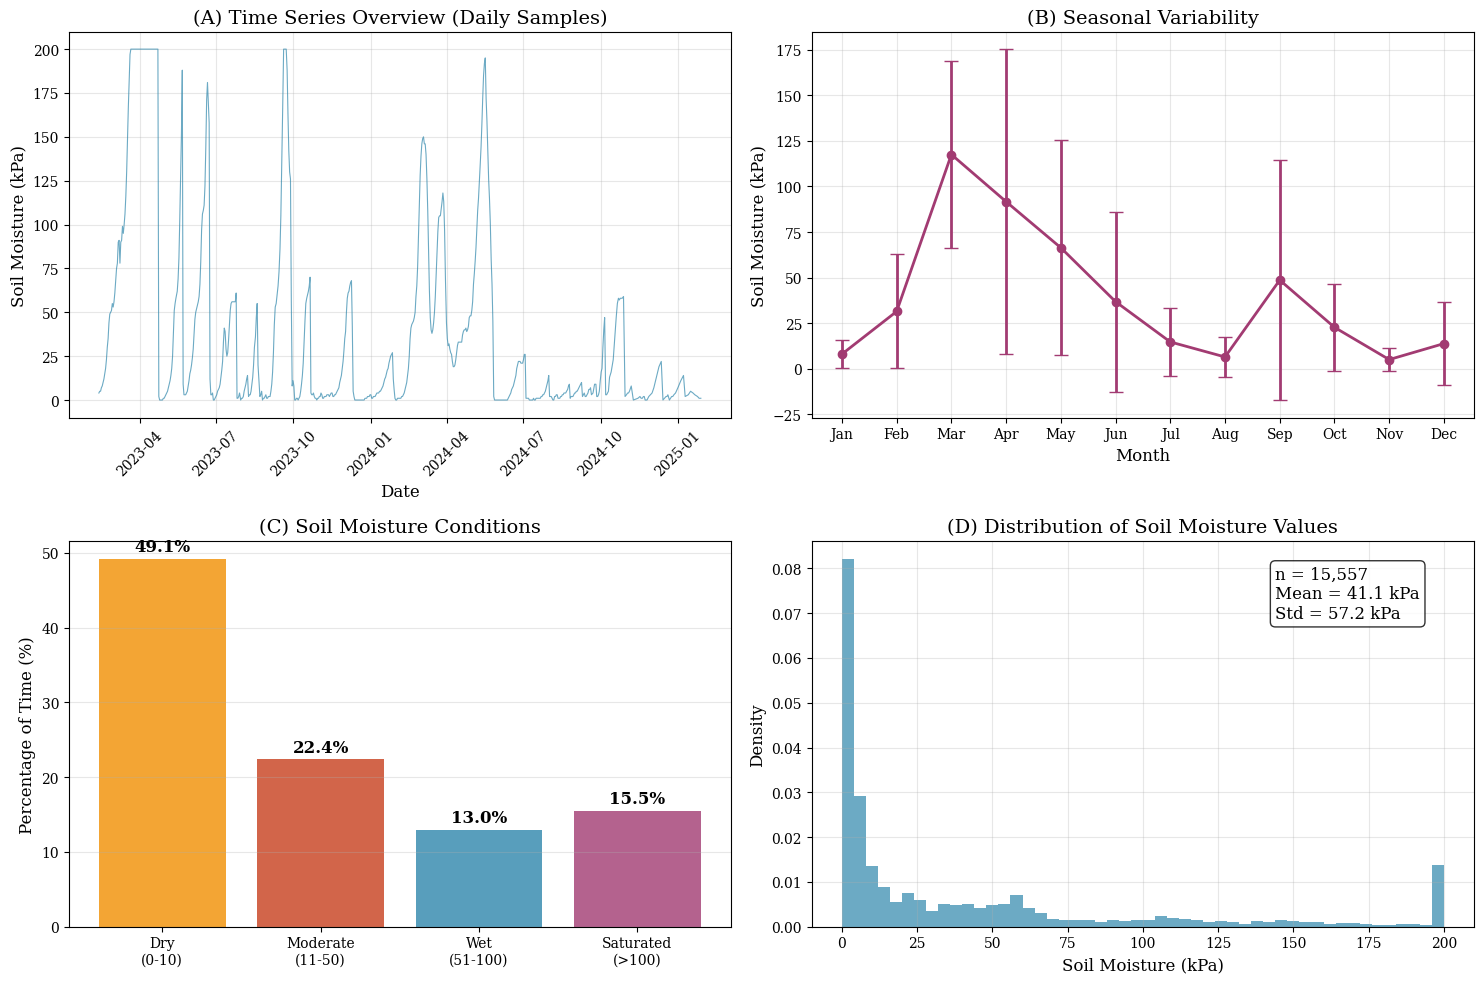

🏗️  Creating Figure 2: Model Architecture...


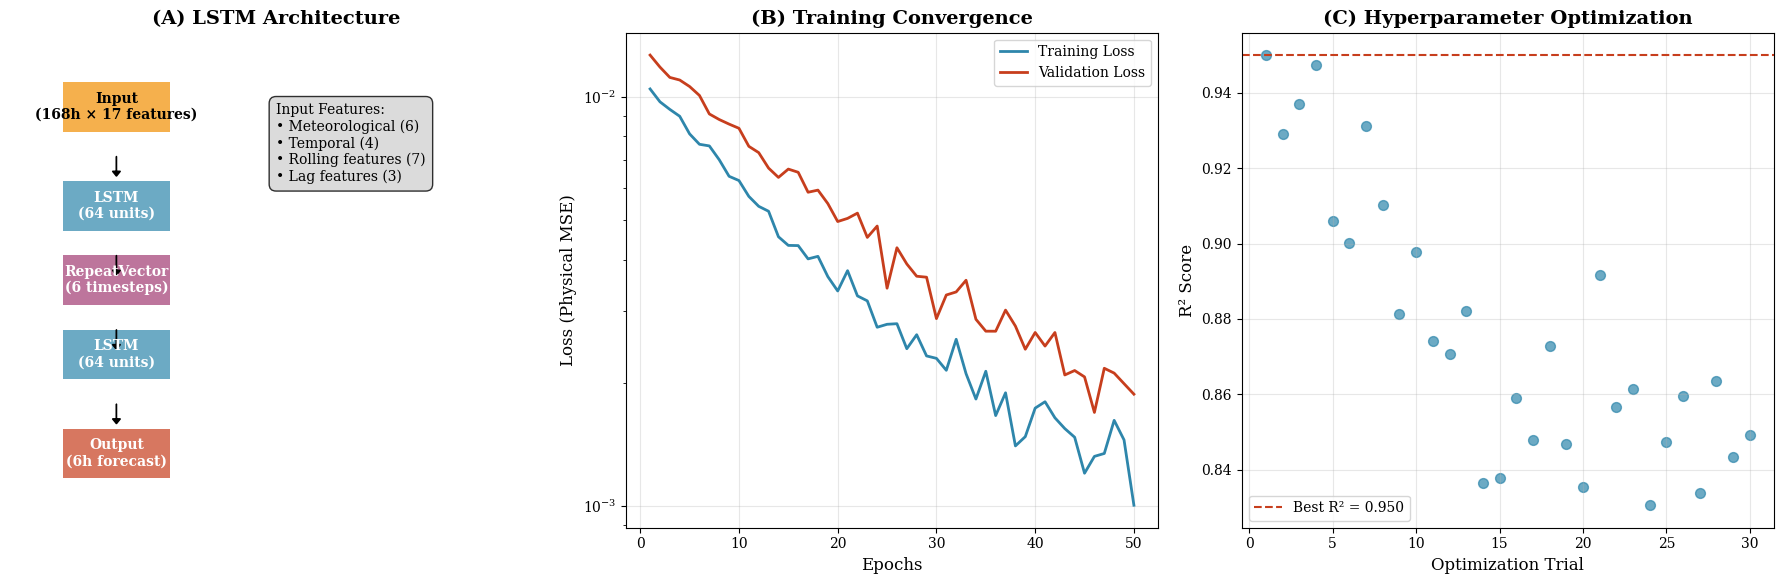

📊 Creating Figure 3: Performance Analysis...


ValueError: x and y must have the same length.

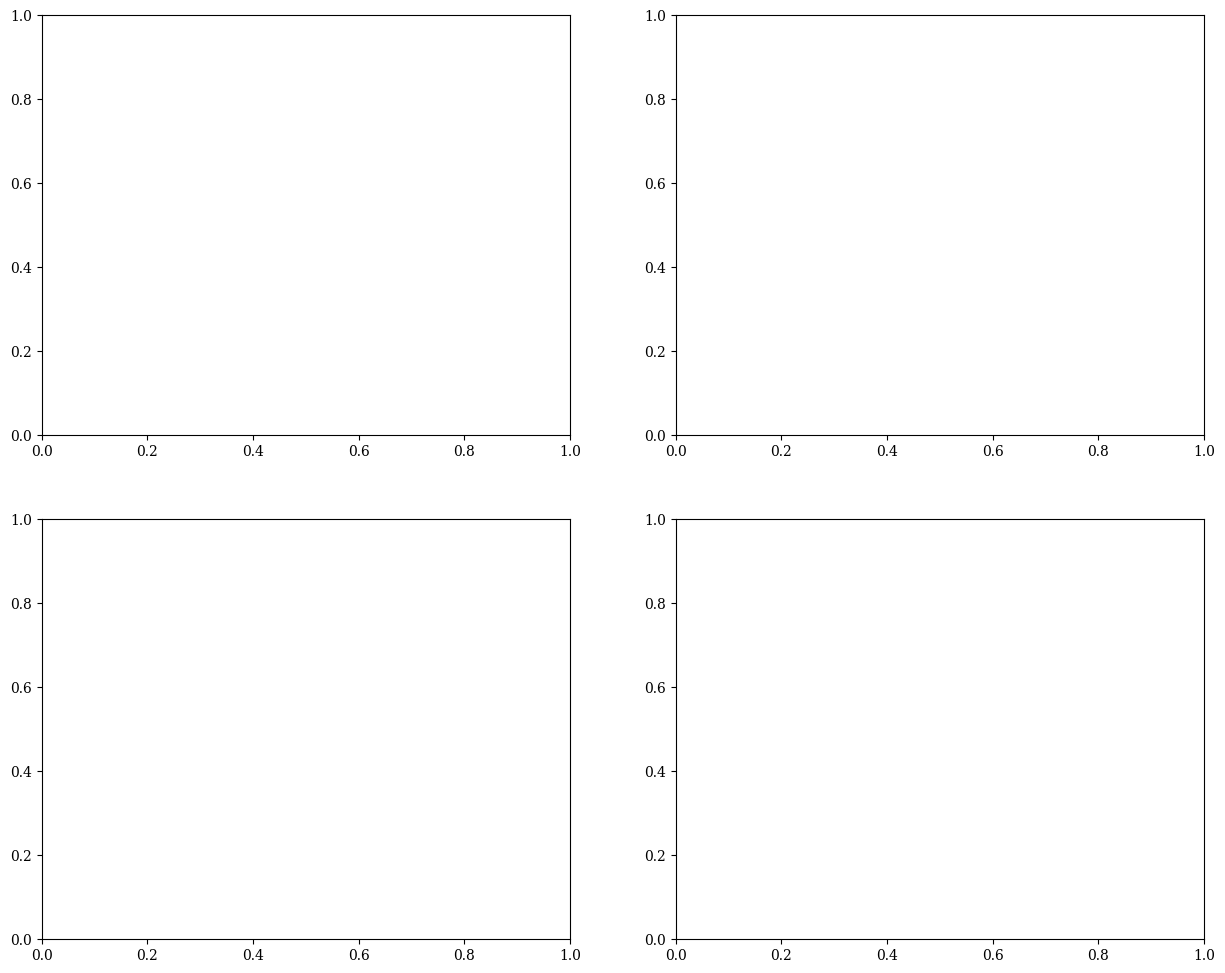

In [ ]:
generate_all_publication_figures(df_v2, y_test_kPa, y_pred_kPa)

## Better Model Evaluation


Performance by soil conditions:


NameError: name 'y_test_original' is not defined

In [ ]:
# prompt: download multiple files generated by scripts in colab

import zipfile
from google.colab import files
from datetime import datetime
# Correctly import the 'files' object from the google.colab module


def zip_results_directory(zip_filename="results.zip"):
  """Zips the 'results' directory for download."""
  with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files_list in os.walk("results"): # Renamed 'files' to 'files_list' to avoid conflict
      for file in files_list:
        zipf.write(os.path.join(root, file),
                   os.path.relpath(os.path.join(root, file), "results"))

  # Use the imported 'files' object for download
  files.download(zip_filename)

# Example usage after your script has run
zip_results_directory('results.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Practical Uses

In [ ]:
# Evaluate specifically for irrigation decision-making
def evaluate_irrigation_alerts(y_true, y_pred, irrigation_thresholds=[100, 150, 200]):
    print("🚜 IRRIGATION ALERT PERFORMANCE:")
    print("Note: Higher kPa = drier soil = more irrigation needed")

    for threshold in irrigation_thresholds:
        print(f"\n📊 Irrigation Threshold: {threshold} kPa")

        # Binary classification: needs irrigation (≥ threshold) vs doesn't
        true_needs_irrigation = y_true >= threshold  # Higher kPa = drier = needs water
        pred_needs_irrigation = y_pred >= threshold

        # Calculate alert accuracy
        correct_alerts = (true_needs_irrigation == pred_needs_irrigation).sum()
        accuracy = correct_alerts / len(y_true) * 100

        # False positives (unnecessary irrigation alerts)
        false_positives = ((pred_needs_irrigation) & (~true_needs_irrigation)).sum()
        false_positive_rate = false_positives / len(y_true) * 100

        # False negatives (missed irrigation needs - CRITICAL!)
        false_negatives = ((~pred_needs_irrigation) & (true_needs_irrigation)).sum()
        false_negative_rate = false_negatives / len(y_true) * 100

        print(f"  ✅ Alert accuracy: {accuracy:.1f}%")
        print(f"  🚨 False alerts (unnecessary irrigation): {false_positive_rate:.1f}%")
        print(f"  ⚠️  Missed irrigation needs (CRITICAL): {false_negative_rate:.1f}%")

        # Economic impact simulation
        if false_positive_rate > 0:
            water_waste = false_positives * 25  # Assume 25mm irrigation each time
            print(f"  💧 Estimated water waste: {water_waste:.0f}mm over test period")

        if false_negative_rate > 0:
            stress_hours = false_negatives * 6  # 6-hour forecast horizon
            print(f"  🌾 Potential crop stress: {stress_hours:.0f} hours over test period")

        # Calculate samples in each category
        total_dry_periods = true_needs_irrigation.sum()
        total_wet_periods = (~true_needs_irrigation).sum()
        print(f"  📈 Data distribution: {total_dry_periods} dry periods, {total_wet_periods} wet periods")

        # Risk assessment
        if false_negative_rate > 10:
            print(f"  🔴 HIGH RISK: Missing {false_negative_rate:.1f}% of irrigation needs!")
        elif false_negative_rate > 5:
            print(f"  🟡 MODERATE RISK: Missing {false_negative_rate:.1f}% of irrigation needs")
        else:
            print(f"  🟢 LOW RISK: Only missing {false_negative_rate:.1f}% of irrigation needs")

# Updated practical irrigation function
def irrigation_alert_system(soil_moisture_forecast, crop_type="general"):
    """
    Practical irrigation alert system for farmers
    Higher kPa = drier soil = more likely to need irrigation
    """
    irrigation_thresholds = {
        "general": 150,        # Most crops start stressing around 100-200 kPa
        "vegetables": 100,     # More sensitive, need water sooner
        "drought_tolerant": 200,  # Can handle drier conditions
        "sensitive_crops": 80,    # Very sensitive to water stress
        "field_capacity": 30      # Optimal growing conditions
    }

    threshold = irrigation_thresholds.get(crop_type, 150)

    if soil_moisture_forecast >= threshold:
        urgency = "URGENT" if soil_moisture_forecast >= threshold + 50 else "SOON"
        return {
            "alert": f"IRRIGATE {urgency}",
            "confidence": "High" if soil_moisture_forecast > threshold + 20 else "Medium",
            "action": f"Soil stress detected ({soil_moisture_forecast:.0f} kPa). Plan irrigation immediately.",
            "risk": "High yield loss risk" if soil_moisture_forecast >= 200 else "Moderate stress"
        }
    elif soil_moisture_forecast >= threshold - 30:
        return {
            "alert": "MONITOR CLOSELY",
            "confidence": "Medium",
            "action": f"Approaching stress threshold. Check again in 12 hours.",
            "next_check": "12 hours"
        }
    else:
        return {
            "alert": "NO IRRIGATION NEEDED",
            "confidence": "High",
            "action": f"Soil moisture adequate ({soil_moisture_forecast:.0f} kPa)",
            "next_check": "24 hours"
        }

# Enhanced evaluation with corrected soil physics
def evaluate_soil_conditions(y_test_kPa, y_pred_kPa):
    print("🌱 CORRECTED SOIL MOISTURE PERFORMANCE ANALYSIS:")
    print("="*60)

    conditions = [
        ("Saturated/Wet (0-30 kPa)", y_test_kPa <= 30),           # Field capacity and below
        ("Optimal (31-80 kPa)", (y_test_kPa > 30) & (y_test_kPa <= 80)),    # Good for most crops
        ("Stress Beginning (81-150 kPa)", (y_test_kPa > 80) & (y_test_kPa <= 150)),  # Start monitoring
        ("High Stress (>150 kPa)", y_test_kPa > 150)             # Immediate irrigation needed
    ]

    total_samples = len(y_test_kPa)

    for name, mask in conditions:
        if mask.sum() > 0:
            y_true_cond = y_test_kPa[mask]
            y_pred_cond = y_pred_kPa[mask]

            r2 = r2_score(y_true_cond, y_pred_cond)
            mae = np.mean(np.abs(y_true_cond - y_pred_cond))
            percentage = mask.sum() / total_samples * 100

            print(f"\n{name}:")
            print(f"  📊 {mask.sum():,} samples ({percentage:.1f}% of data)")
            print(f"  📈 R² = {r2:.3f}")
            print(f"  📏 MAE = {mae:.1f} kPa")

            # Agricultural significance
            if "Stress" in name or "High" in name:
                print(f"  🚨 CRITICAL for irrigation decisions!")
            elif "Optimal" in name:
                print(f"  🌱 Ideal growing conditions")
            else:
                print(f"  💧 Excess moisture conditions")

# Run the evaluations
print("IRRIGATION ANALYSIS")
print("="*50)
evaluate_irrigation_alerts(y_test_kPa, y_pred_kPa)
print("\n")
evaluate_soil_conditions(y_test_kPa, y_pred_kPa)

🚜 IRRIGATION ALERT PERFORMANCE:

📊 Wilting Point: 15 kPa
  ✅ Alert accuracy: 96.7%
  🚨 False alerts (unnecessary irrigation): 2.9%
  ⚠️  Missed irrigation needs: 0.4%
  💧 Estimated water waste: 12600mm over test period
  🌾 Potential crop stress: 456 hours over test period

📊 Wilting Point: 20 kPa
  ✅ Alert accuracy: 98.3%
  🚨 False alerts (unnecessary irrigation): 1.4%
  ⚠️  Missed irrigation needs: 0.3%
  💧 Estimated water waste: 6025mm over test period
  🌾 Potential crop stress: 324 hours over test period

📊 Wilting Point: 25 kPa
  ✅ Alert accuracy: 98.5%
  🚨 False alerts (unnecessary irrigation): 1.0%
  ⚠️  Missed irrigation needs: 0.4%
  💧 Estimated water waste: 4500mm over test period
  🌾 Potential crop stress: 462 hours over test period


In [ ]:
def irrigation_alert_system(soil_moisture_forecast, crop_type="general"):
    """
    Practical irrigation alert system for farmers
    """
    wilting_points = {
        "general": 20,
        "vegetables": 15,
        "drought_tolerant": 30,
        "sensitive_crops": 12
    }

    wp = wilting_points.get(crop_type, 20)

    if soil_moisture_forecast <= wp:
        return {
            "alert": "IRRIGATE SOON",
            "confidence": "High" if soil_moisture_forecast < wp-5 else "Medium",
            "action": f"Plan irrigation within 6-12 hours"
        }
    else:
        return {
            "alert": "NO IRRIGATION NEEDED",
            "confidence": "High",
            "next_check": "24 hours"
        }

## Debug unscaling

In [ ]:
# Debug unscaling
print("🔍 UNSCALING DIAGNOSIS:")
print(f"Original full dataset range: {df_v2[target].min():.1f} - {df_v2[target].max():.1f} kPa")
print(f"Test set range: {df_test[target].min():.1f} - {df_test[target].max():.1f} kPa")
print(f"Scaled y_test range: {y_test.min():.3f} - {y_test.max():.3f}")
#print(f"Scaled y_pred range: {y_pred.min():.3f} - {y_pred.max():.3f}")
#print(f"Unscaled y_test range: {y_test_original.min():.1f} - {y_test_original.max():.1f} kPa")
#print(f"Unscaled y_pred range: {y_pred_original.min():.1f} - {y_pred_original.max():.1f} kPa")

# Check if scaler is working correctly
test_values = np.array([[0.0], [1.0]])  # Min and max scaled values
unscaled_test = target_scaler.inverse_transform(test_values)
print(f"Scaler test - 0.0 maps to: {unscaled_test[0,0]:.1f} kPa")
print(f"Scaler test - 1.0 maps to: {unscaled_test[1,0]:.1f} kPa")

🔍 UNSCALING DIAGNOSIS:
Original full dataset range: 0.0 - 200.0 kPa
Test set range: 0.0 - 61.0 kPa
Scaled y_test range: 0.000 - 61.000
Scaler test - 0.0 maps to: 0.0 kPa
Scaler test - 1.0 maps to: 200.0 kPa
